# Phân tích phim truyền thông và xã hội

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

Trong những năm gần đây, các nhà phân tích và nhà đầu tư ngày càng quan tâm đến việc đánh giá rủi ro tài chính trong sản xuất phim. Nghiên cứu này sử dụng phân tích hồi quy tuyến tính bội để dự đoán thành công về mặt tài chính của phim và nghiên cứu mối quan hệ giữa số lần chiếu và năm.

Kết quả đạt được

## Bảng phân công công việc

## Phát biểu bài toán

Mục tiêu chính của đồ án là khám phá và phân tích tổng doanh thu của phim trong hai năm 2014 và 2015 cũng như kiểm tra mối quan hệ và ý nghĩa của một số biến giải thích. Hơn nữa, đồ án xây dựng một mô hình hồi quy tối ưu để đưa ra dự đoán về sự thành công về mặt tài chính, tức là tổng doanh thu của một bộ phim trong hai năm 2014 và 2015. 

## Giới thiệu về dữ liệu

Bộ dữ liệu phim truyền thông và xã hội (conventional and social media dataset) được sử dụng trong đồ án này có cấu trúc tương đối đơn giản mà một số người có ích kiến thức về phim truyền hình cũng có thể hiểu được. Vấn đề chính của bộ dữ liệu là missing values, và chúng tôi sẽ cố gắng xử lý nó bằng một số kỹ thuật đã biết.

Ngành công nghiệp điện ảnh là một ngành đóng góp đáng kể cho nền kinh tế của một quốc gia và là một nhà tuyển dụng lớn tại Hoa Kỳ. Do chi phí lớn liên quan đến sản xuất phim, các nhà phân tích cần nghiên cứu và hiểu các biến số chính góp phần vào thành công về mặt thương mại và tài chính của một bộ phim. Đồ án có thể cung cấp thông tin chi tiết về các tính năng chính góp phần vào thành công về mặt tài chính của các bộ phim và thúc đẩy nghiên cứu trong tương lai để xem xét mối quan hệ giữa các biến giải thích đặc biệt độc đáo trong tập dữ liệu. Hơn nữa nó còn có thể giúp các nhà sản xuất phim xác định những tính năng nào cần tập trung vào trong giai đoạn quảng bá để cải thiện thành công của bộ phim.

## Import thư viện

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)

library(pls)
# library(caret)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



== Welcome to TidyDensity ===========================================================================
If you find this package useful, please leave a star: 
   https://github.com/spsanderson/TidyDensity'

If you enco

## Hàm phụ trợ

Hàm phụ trợ cho việc loại bỏ đa cộng tuyến

In [2]:
# Hàm tiền xử lý dữ liệu với box-cox
bc_transform <- function(df) {
    col.names <- names(df)

    transformed_df <- df
    
    for (name in names(df))
    {
        col.name <- name

        print(col.name)

        # Rút trích biến phản hồi
        response_variable <- df[[col.name]]
        
        if (!is.numeric(response_variable)) {
            print(col.name)
            stop("The column to be transformed must be numeric.")
        }
        
        if (any(response_variable <= 0)) {
            # Shift the values to be positive
            shift_value <- abs(min(response_variable)) + 1
            response_variable <- response_variable + shift_value
        }
        
        # Áp dụng box-cox transform để tìm lambda tối ưu
        boxcox_result <- boxcox(lm(response_variable ~ 1), plotit = FALSE)
        optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
        print(paste("Optimal lambda:", optimal_lambda))
        
        # Sử dụng lambda tối ưu để biến đổi dữ liệu
        if (optimal_lambda == 0) {
            transformed_response <- log(response_variable)
        } else {
            transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
        }
        
        # Gán biến đã được biến đổi
        transformed_df[[col.name]] <- transformed_response
    }
    
    return(transformed_df)
}

library(MLmetrics)
indicator <- function(model, y_pred, y_true) {
     adj.r.sq <- summary(model)$adj.r.squared
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("Adjusted R-squared: ", round(adj.r.sq, 4)))
     print(paste0("MSE: ", round(mse, 4)))
     print(paste0("RMSE: ", round(rmse, 4)))
     print(paste0("MAE: ", round(mae, 4)))
}

metrics <- function(y_pred, y_true){
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("MSE: ", round(mse, 6)))
     print(paste0("RMSE: ", round(rmse, 6)))
     print(paste0("MAE: ", round(mae, 6)))
     corPredAct <- cor(y_pred, y_true)
     print(paste0("Correlation: ", round(corPredAct, 6)))
     print(paste0("R^2 between y_pred & y_true: ", round(corPredAct^2, 6)))
}

CheckNormal <- function(model) {
     hist(model$residuals, breaks = 30)
     shaptest <- shapiro.test(model$residuals)
     print(shaptest)
     if (shaptest$p.value <= 0.05) {
          print("H0 rejected: the residuals are NOT distributed normally")
     } else {
          print("H0 failed to reject: the residuals ARE distributed normally")
     }
}

library(lmtest)
CheckHomos <- function(model){
     plot(model$fitted.values, model$residuals)
     abline(h = 0, col = "red")
     BP <- bptest(model)
     print(BP)
     if (BP$p.value <= 0.05) {
          print("H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)")
     } else {
          print("H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)")
     }
}


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall




## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read_excel("../../data/part1/CSM.xlsx", sheet = 1)
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie              : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year               : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings            : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre              : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross              : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget             : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens            : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel             : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment          : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views              : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes              : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes           : num [1:231] 425 61 34 132 610 

In [4]:
# Thay đổi tên biến `Aggregate Followers` thành `AggregateFollowers`
names(raw_data)[names(raw_data) == 'Aggregate Followers'] <- 'AggregateFollowers'

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [5]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 231 dòng và 14 cột
dim(raw_data)

[1] 231  14

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [6]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- table(raw_data[duplicated(raw_data), ])
duplicates # Không có dữ liệu trùng lặp

Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,AggregateFollowers
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


### Mỗi cột mang ý nghĩa gì?

In [7]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie             : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year              : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings           : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre             : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross             : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget            : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens           : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel            : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment         : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views             : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes             : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes          : num [1:231] 425 61 34 132 610 7 419 197 41

Ý nghĩa từng cột:
- `Movie`: tên phim => Trong dữ liệu có kiểu dữ liệu chr => Chưa phù hợp => **Nên chuyển đổi biến này sang kiểu phân loại (Categorical)**
- `Year`: năm phát hành => Trong dữ liệu có kiểu dữ liệu num => phân loại biến kiểu số rời rạc (Numerical, Discretization) => Phù hợp
- `Ratings`: điểm đánh giá => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Genre`: thể loại phim => Trong dữ liệu có kiểu dữ liệu num => Chưa phù hợp => **Nên chuyển đổi biến này sang kiểu phân loại (Categorical)**
- `Gross`: tổng doanh thu => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Budget`: tổng chi phí => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Screens`: số rạp chiếu => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization) => Phù hợp
- `Sequel`: phần phim => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization) => Phù hợp
- `Sentiment`: ý kiến khán giả => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization) => Phù hợp
- `Views`: số lượt xem => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization) => Phù hợp
- `Likes`: số lượt thích => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization) => Phù hợp
- `Dislikes`: số lượt chê => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization) => Phù hợp
- `Comments`: số bình luận => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization) => Phù hợp
- `Aggregate Followers`: số người theo dõi => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization) => Phù hợp

Ta thấy ý nghĩa của cột `Likes` và `Dislikes` đối ngẫu nhau, nên ta chỉ cần giữ lại một cột là được. Trong trường hợp này, ta chọn cột `Likes`

In [8]:
raw_data <- raw_data[,-c(12)]

### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

In [9]:
# 2.Movie 
is.factor(raw_data$Movie) #False

[1] FALSE

In [10]:
# Modifications
processed_data <- raw_data
processed_data$Genre <- as.factor(processed_data$Genre)
processed_data$Movie <- as.factor(processed_data$Movie)
processed_data$Year <- as.factor(processed_data$Year)

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [11]:
# Hàm tính toán tỷ lệ missing value
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Hàm tính toán trung vị (median)
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 25% (Q1)
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 75% (Q3)
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [12]:
# Lựa chọn những cột kiểu số
num_col_info_df <- as.data.frame(processed_data) %>% select_if(is.numeric)

# Tổng hợp các kết quả thống kê
num_col_info_df <- as.data.frame(processed_data) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

# In kết quả ra
print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 30 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 10 × 7
   variable           missing     min      lower     median      upper       max
   <chr>                <dbl>   <dbl>      <dbl>      <dbl>      <dbl>     <dbl>
 1 Ratings                0       3.1        5.8        6.5        7.1    8.7 e0
 2 Gross                  0    2470   10300000   37400000   89350000      6.43e8
 3 Budget                 0.4 70000    9000000   28000000   65000000      2.5 e8
 4 Screens                4.3     2        449       2777       3372      4.32e3
 5 Sequel                 0       1          1          1          1      7   e0
 6 Sentiment              0     -38          0          0          5.5    2.9 e1
 7 Views                  0     698     623302    2409338    5217380.     3.26e7
 8 Likes                  0       1       1776.      6096      15248.     3.71e5
 9 Comments               0       0        248.       837       2137      3.84e4
10 AggregateFollowers    15.2  1066     183025    1052600    3694500      3.10e7


**Nhận xét**
- Dữ liệu có hiện tượng missing values.
- Cụ thể, ta thấy biến `Aggregate Followers` có tỷ lệ missing 15.2%, biến `Screens` có tỷ lệ 4.3% và biến `Budget` có tỷ lệ missing 0.4%.
- Có những bộ phim không có likes/ dislikes/ comments, ta sẽ loại bỏ những dòng này.

Kiểm tra lại với hàm `summary`

In [13]:
print(summary(as.data.frame(processed_data) %>% select_if(is.numeric)))

    Ratings          Gross               Budget             Screens    
 Min.   :3.100   Min.   :     2470   Min.   :    70000   Min.   :   2  
 1st Qu.:5.800   1st Qu.: 10300000   1st Qu.:  9000000   1st Qu.: 449  
 Median :6.500   Median : 37400000   Median : 28000000   Median :2777  
 Mean   :6.442   Mean   : 68066033   Mean   : 47921730   Mean   :2209  
 3rd Qu.:7.100   3rd Qu.: 89350000   3rd Qu.: 65000000   3rd Qu.:3372  
 Max.   :8.700   Max.   :643000000   Max.   :250000000   Max.   :4324  
                                     NA's   :1           NA's   :10    
     Sequel        Sentiment          Views              Likes       
 Min.   :1.000   Min.   :-38.00   Min.   :     698   Min.   :     1  
 1st Qu.:1.000   1st Qu.:  0.00   1st Qu.:  623302   1st Qu.:  1776  
 Median :1.000   Median :  0.00   Median : 2409338   Median :  6096  
 Mean   :1.359   Mean   :  2.81   Mean   : 3712851   Mean   : 12732  
 3rd Qu.:1.000   3rd Qu.:  5.50   3rd Qu.: 5217380   3rd Qu.: 15248  
 Max

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

Ta xem xét số lượng phần tử duy nhất (unique) của biến Movie

In [14]:
# Tính toán tỷ lệ giá trị missing value
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Function to calculate number of unique values
num_values <- function(s) {
  s <- as.character(s)  # Convert factors to character
  s <- strsplit(s, ";")
  s <- unlist(s)
  length(unique(s))
}

# Hàm tính toán tỉ lệ các giá trị của biến của phân loại
value_ratios <- function(s) {
  s <- as.character(s)  # Convert factors to character
  s <- strsplit(s, ";")
  s <- unlist(s)
  totalCount <- sum(!is.na(s))
  value_counts <- table(s)
  ratios <- round((value_counts / totalCount) * 100, 1)
  as.list(ratios)
}

# Lựa chọn các cột có kiểu phân loại
cat_col_info_df <- processed_data %>%
  select_if(~ is.character(.) || is.factor(.))

# Hàm tổng hợp kết quả cho mỗi cột
aggregate_results <- function(df) {
  result <- data.frame(
    column = names(df),
    missing_ratio = sapply(df, missing_ratio),
    num_values = sapply(df, num_values),
    value_ratios = I(lapply(df, value_ratios))
  )
  result
}

# Áp dụng hàm tổng hợp kết quả
cat_col_info_df <- aggregate_results(cat_col_info_df)

# In kết quả ra
print(cat_col_info_df)

      column missing_ratio num_values value_ratios
Movie  Movie             0        231 0.4, 0.4....
Year    Year             0          2   70.6, 29.4
Genre  Genre             0         11 28.1, 5.....


Ta thấy số lượng phần tử đơn trong Movie có số lượng gần record trong dữ liệu. 

=> Đa số bộ phim chỉ có một phần phim

=> Tên phim ít có ảnh hưởng đến doanh thu

=> Ta có thể loại bỏ biến này trong quá trình phân tích phía sau.

In [15]:
length(unique(processed_data$Movie))

[1] 231

Ta thấy biến `Genre` có 11 giá trị đơn, bao gồm 8, 1, 3, 10, 15, 12, 9, 2, 7, 6, 4.

In [16]:
unique(processed_data$Genre)
length(unique(processed_data$Genre))

[1] 8  1  3  10 15 12 9  2  7  6  4 
Levels: 1 2 3 4 6 7 8 9 10 12 15

[1] 11

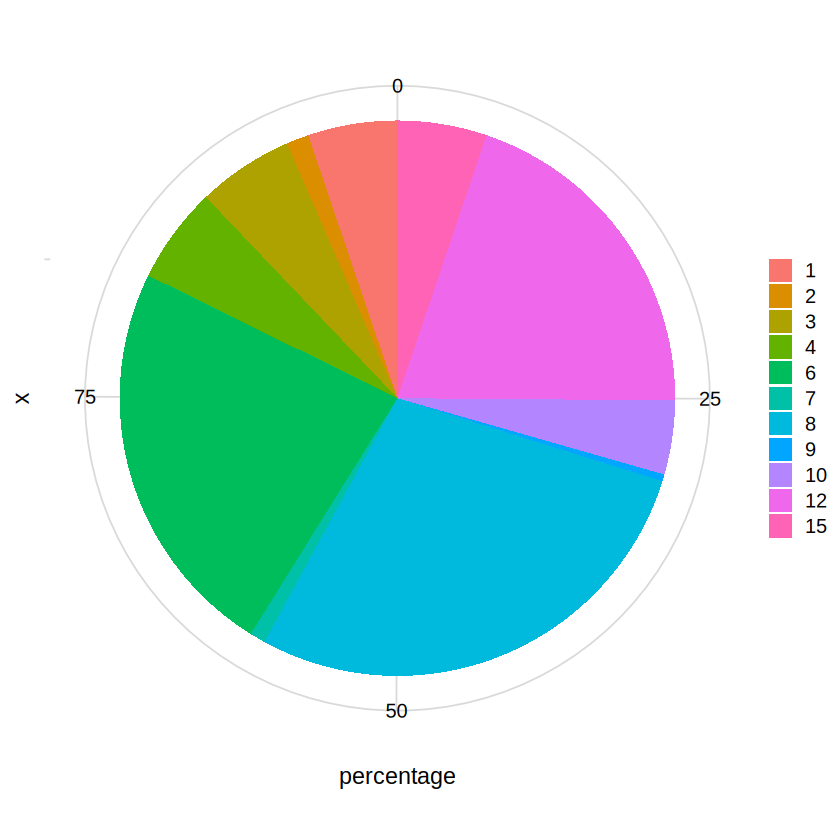

In [17]:
df <- data.frame(
    year = unique(processed_data$Genre),
    percentage = c(t(as.data.frame(cat_col_info_df$value_ratios[[3]])[1, ]))
)

bp<- ggplot(df, aes(x="", y=percentage, fill=year))+
geom_bar(width = 1, stat = "identity")
pie <- bp + coord_polar("y", start=0) + theme_minimal_grid() + theme(legend.title = element_blank())
pie

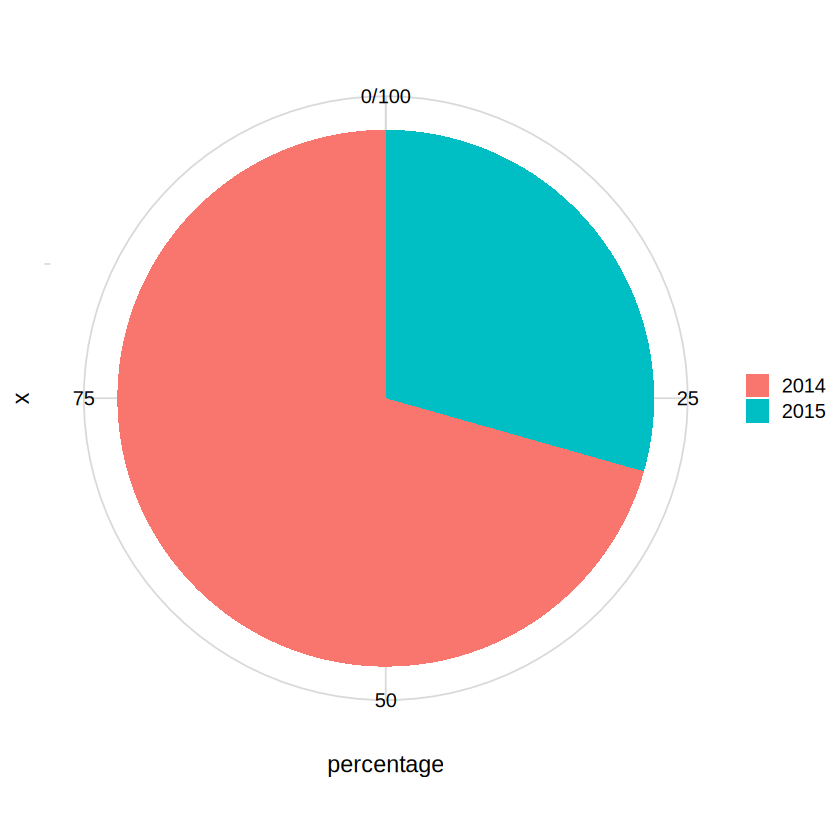

In [18]:
df <- data.frame(
    year = unique(processed_data$Year),
    percentage = c(t(as.data.frame(cat_col_info_df$value_ratios[[2]])[1, ]))
)

bp<- ggplot(df, aes(x="", y=percentage, fill=year))+
geom_bar(width = 1, stat = "identity")
pie <- bp + coord_polar("y", start=0) + theme_minimal_grid() + theme(legend.title = element_blank())
pie

Loại bỏ ba biến Moive, Year, Genre

In [19]:
csm_df = processed_data[, -c(1, 2, 4)]

### Thử xử lý dữ liệu bị thiếu bằng PCA

Tham khảo từ bài báo **[Principal component analysis with missing values: a comparative survey of methods](https://link.springer.com/article/10.1007/s11258-014-0406-z)** của Julie Josse và Stéphane Dray.

In [20]:
# Ước lượng thành phần chính
# Loại trừ các biến không phải định lượng: Movie
nPCs <- estim_ncpPCA(csm_df)
print(nPCs)

$ncp
[1] 2

$criterion
           0            1            2            3            4            5 
1.105170e+15 6.996252e+14 4.736811e+14 5.889466e+14 7.572650e+14 1.068085e+15 



In [21]:
# Xử lý missing value
csm_df <- imputePCA(csm_df, ncp = nPCs$ncp, scale = TRUE)
csm_df <- csm_df$completeObs

In [22]:
print(apply(csm_df, 2, function(x) {sum(is.na(x))/length(x)*100}))

           Ratings              Gross             Budget            Screens 
                 0                  0                  0                  0 
            Sequel          Sentiment              Views              Likes 
                 0                  0                  0                  0 
          Comments AggregateFollowers 
                 0                  0 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 35 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


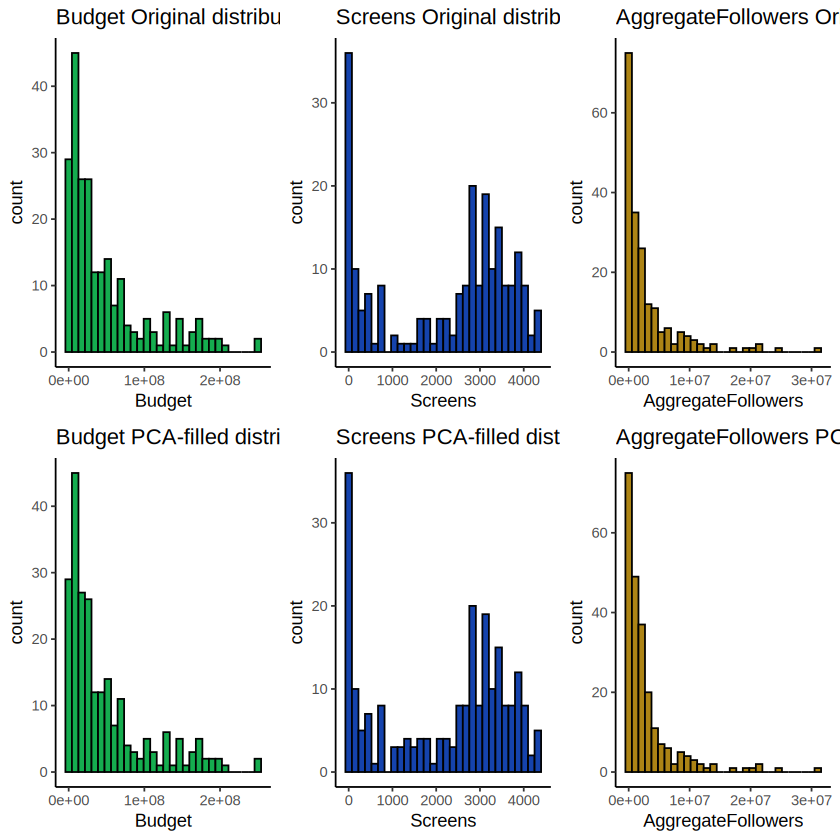

In [23]:
# Trực quan phân phối trước và sau khi fill missing value
h1 <- ggplot(raw_data, aes(x = Budget)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Budget Original distribution") +
  theme_classic()
h2 <- ggplot(raw_data, aes(x = Screens)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Screens Original distribution") +
  theme_classic()
h3 <- ggplot(raw_data, aes(x = AggregateFollowers )) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("AggregateFollowers Original distribution") +
  theme_classic()

  
h4 <- ggplot(csm_df, aes(x = Budget)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Budget PCA-filled distribution") +
  theme_classic()
h5 <- ggplot(csm_df, aes(x = Screens)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Screens PCA-filled distribution") +
  theme_classic()
h6 <- ggplot(csm_df, aes(x = AggregateFollowers )) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("AggregateFollowers PCA-filled distribution") +
  theme_classic()

plot_grid(h1, h2, h3, h4, h5, h6, nrow = 2, ncol = 3, rel_widths = c(1, 1), rel_heights = c(1, 1))

## Quay lại bước phân tích xen kẽ với tiền xử lý dữ liệu

In [36]:
names(cleaned_df)

[1] "Ratings"            "Budget"             "Screens"           
[4] "Sequel"             "Sentiment"          "Views"             
[7] "Likes"              "AggregateFollowers" "Gross"

### Phân tích biến `Ratings`

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


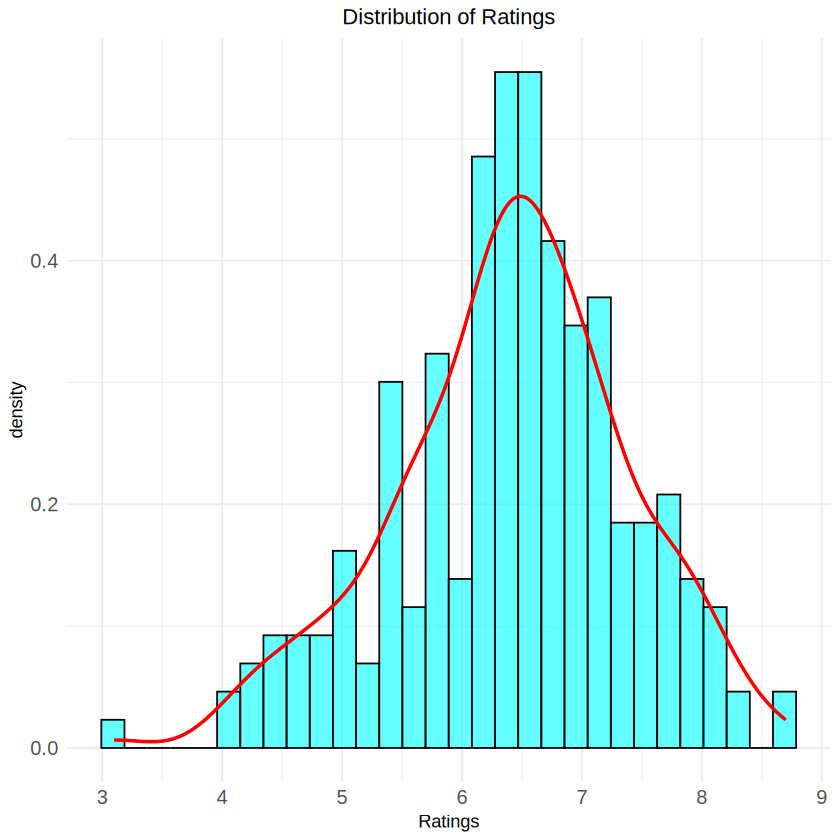

In [37]:
ggplot(cleaned_df, aes(x = Ratings)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Ratings") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

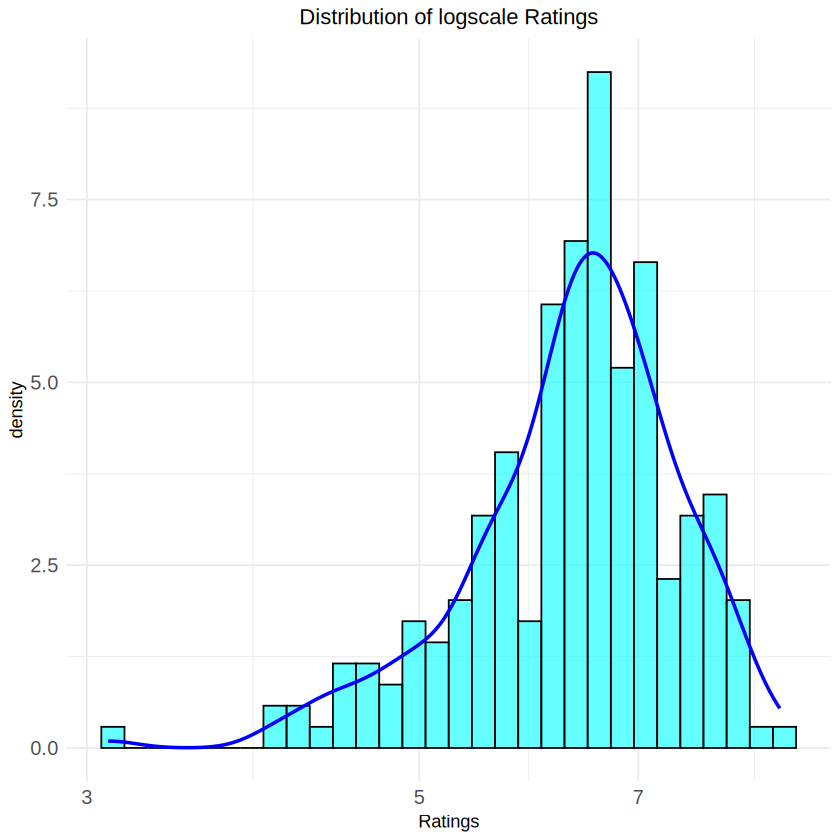

In [38]:
ggplot(cleaned_df, aes(x = Ratings)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale Ratings") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  1.71717171717172"


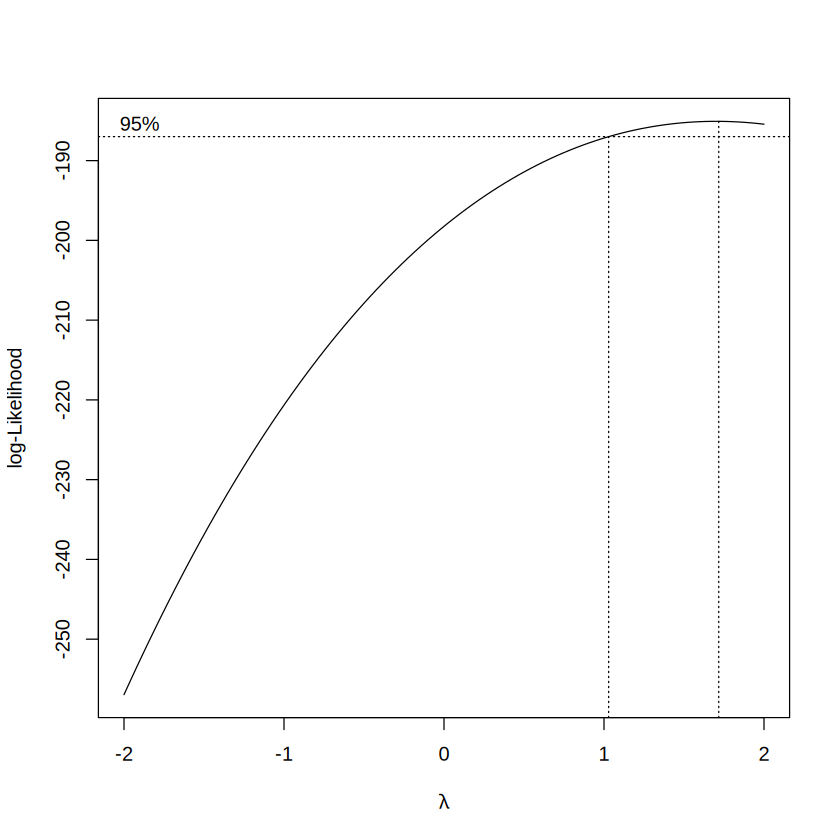

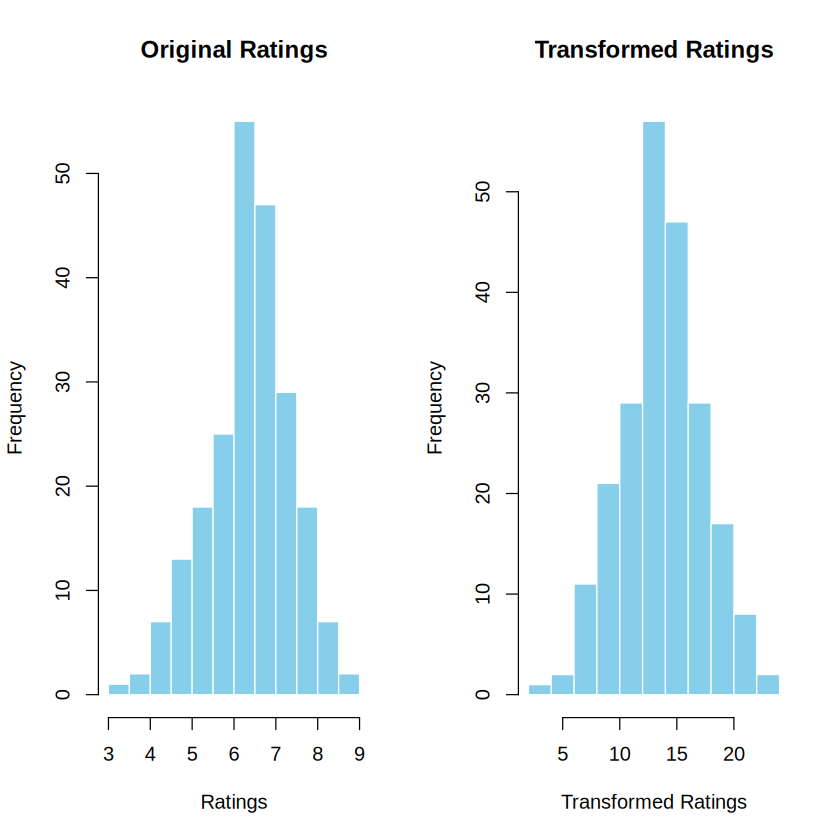

In [39]:
response_variable <- cleaned_df$Ratings 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Ratings", xlab = "Ratings", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Ratings", xlab = "Transformed Ratings", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Phân tích biến `Budget`

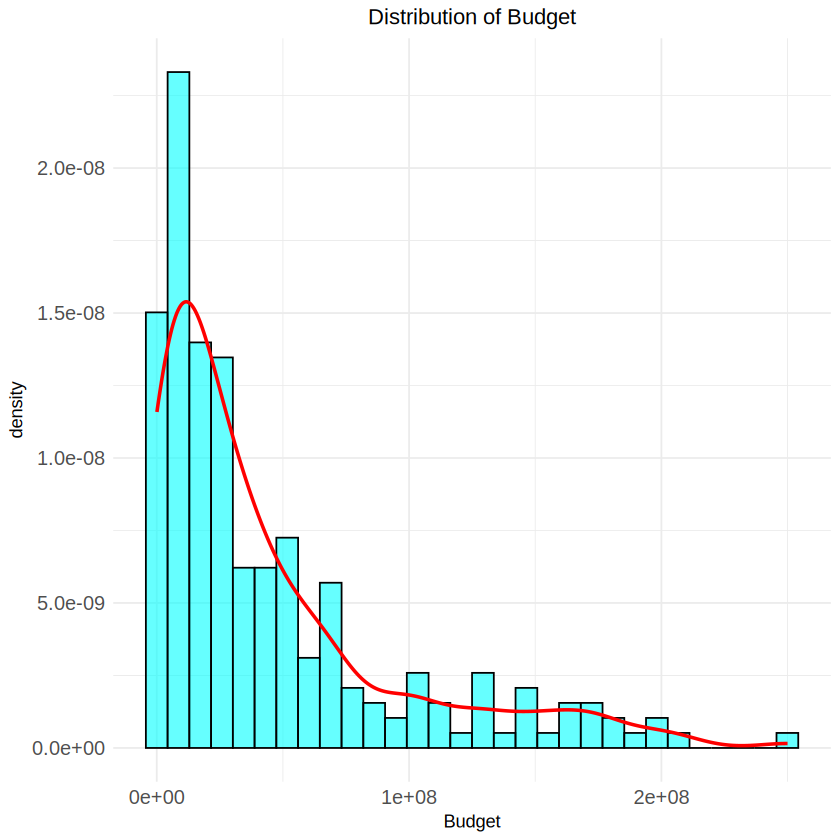

In [40]:
ggplot(cleaned_df, aes(x = Budget)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Budget") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

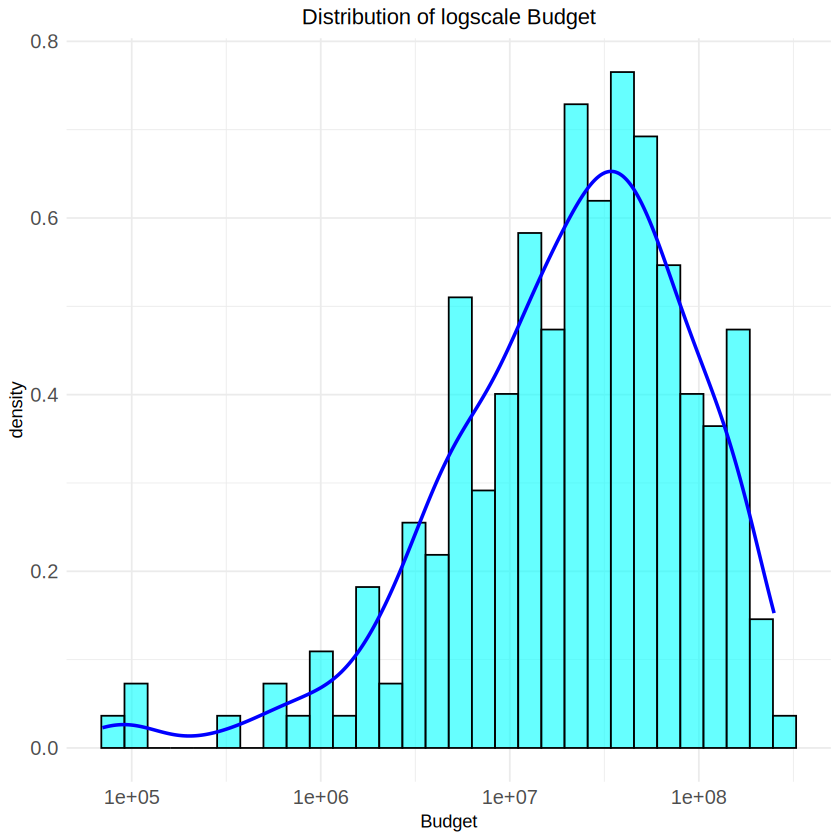

In [41]:
ggplot(cleaned_df, aes(x = Budget)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale Budget") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.222222222222222"


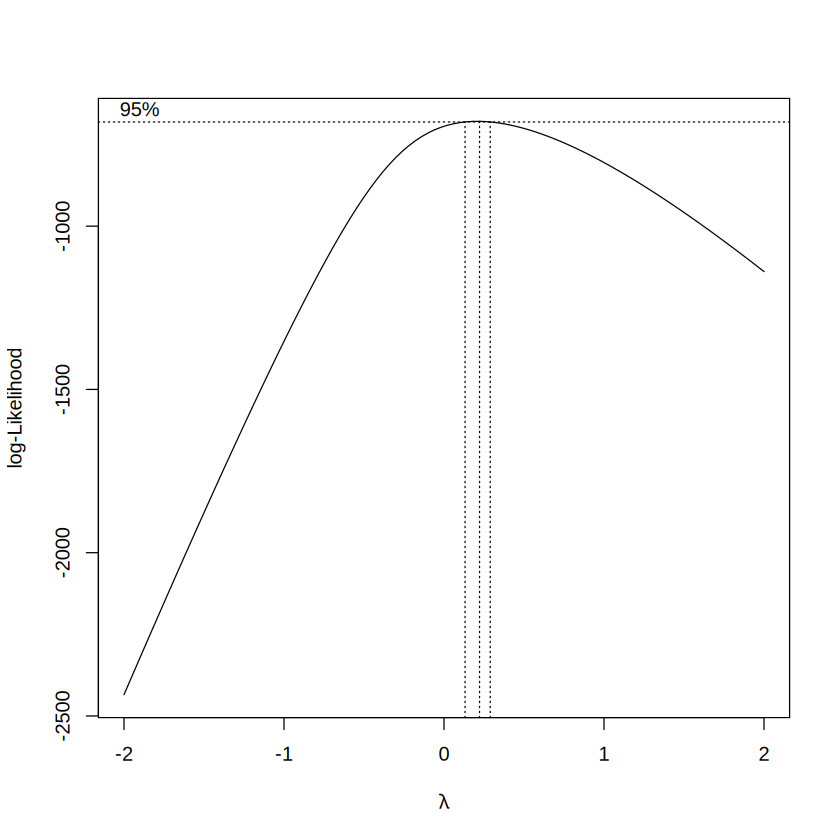

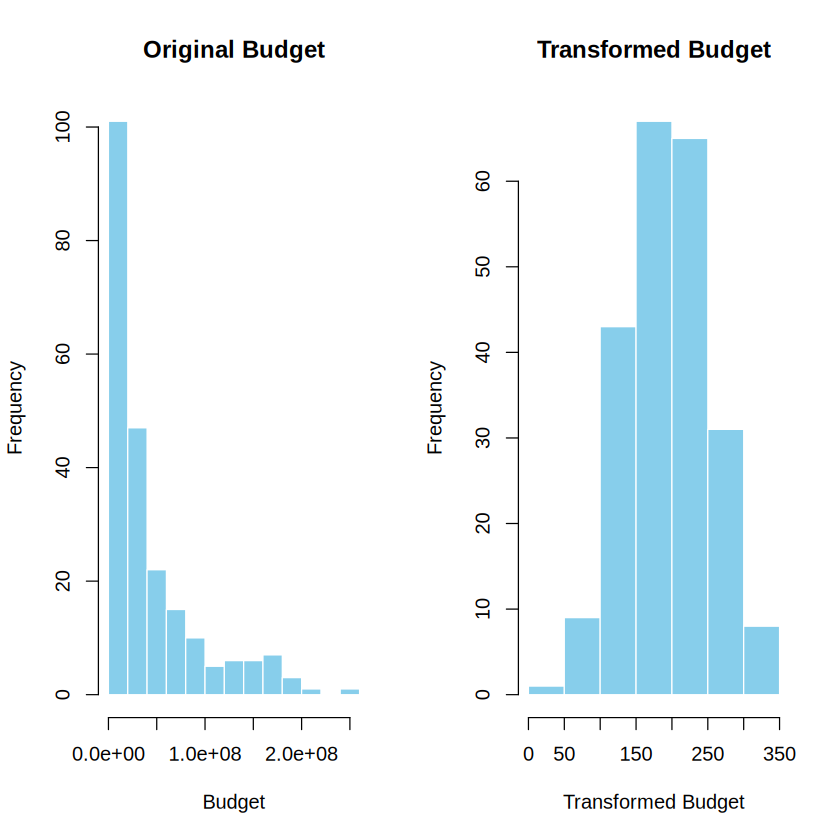

In [42]:
response_variable <- cleaned_df$Budget 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Budget", xlab = "Budget", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Budget", xlab = "Transformed Budget", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Phân tích biến `Screens`

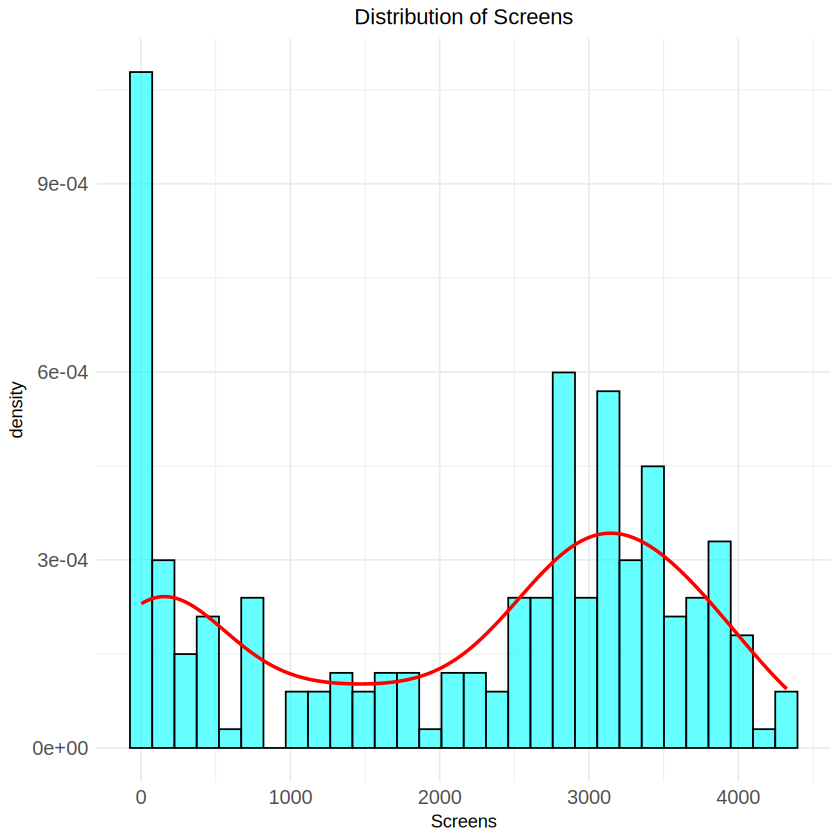

In [43]:
ggplot(cleaned_df, aes(x = Screens)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Screens") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

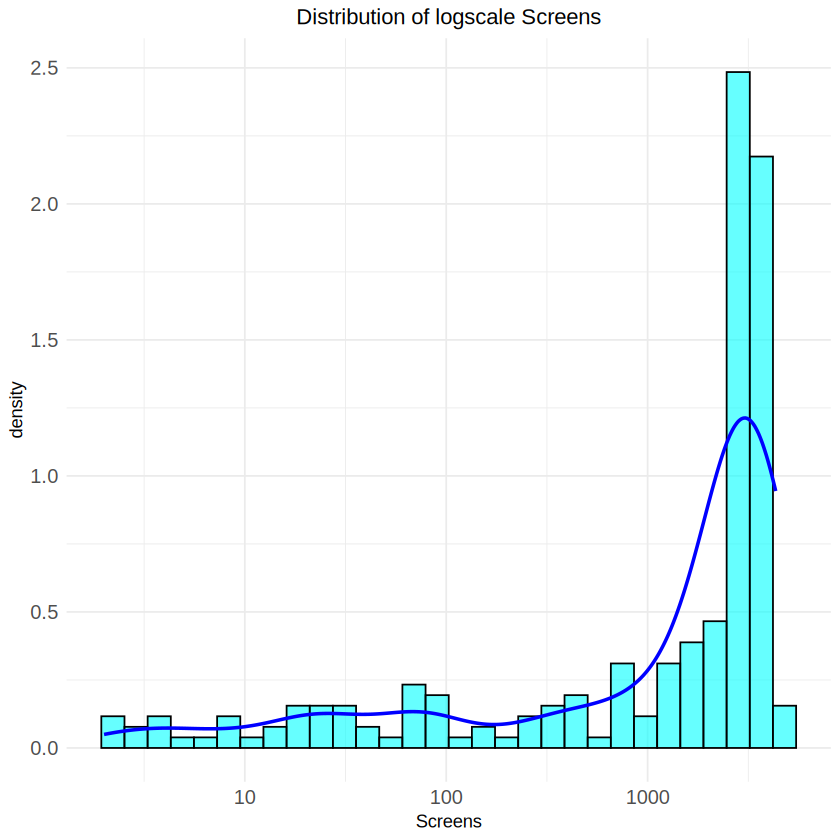

In [44]:
ggplot(cleaned_df, aes(x = Screens)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale Screens") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.545454545454546"


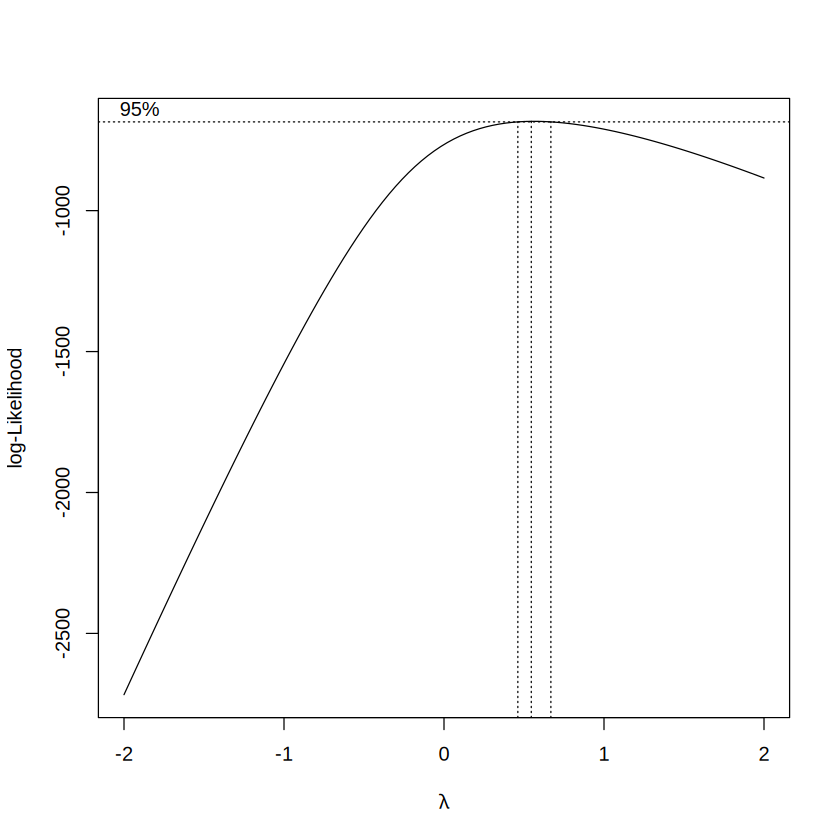

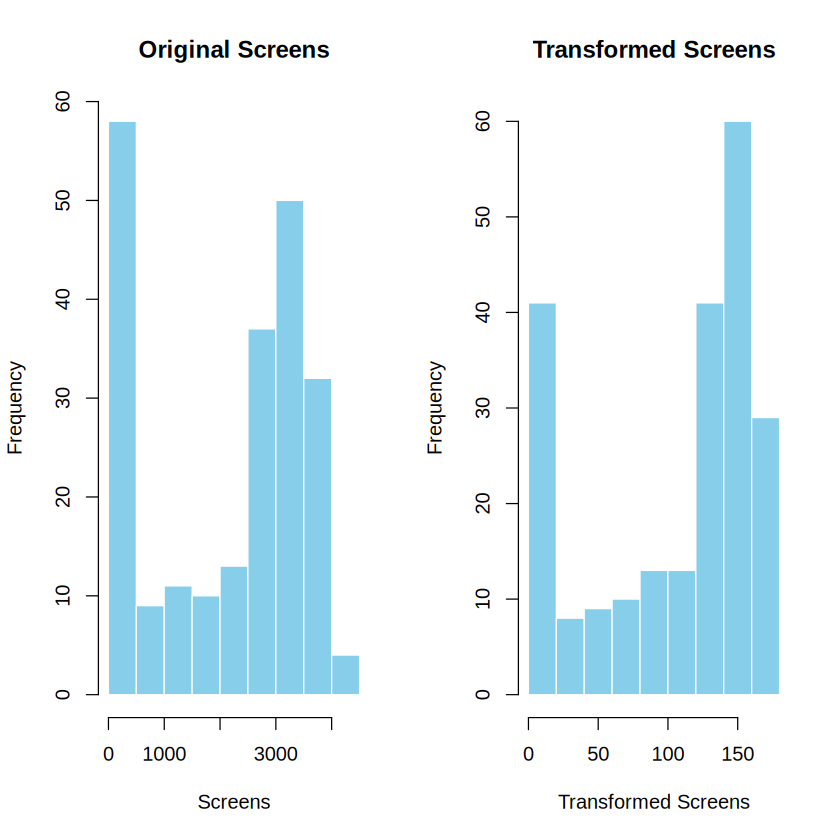

In [45]:
response_variable <- cleaned_df$Screens 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Screens", xlab = "Screens", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Screens", xlab = "Transformed Screens", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Phân tích biến `Sequel`

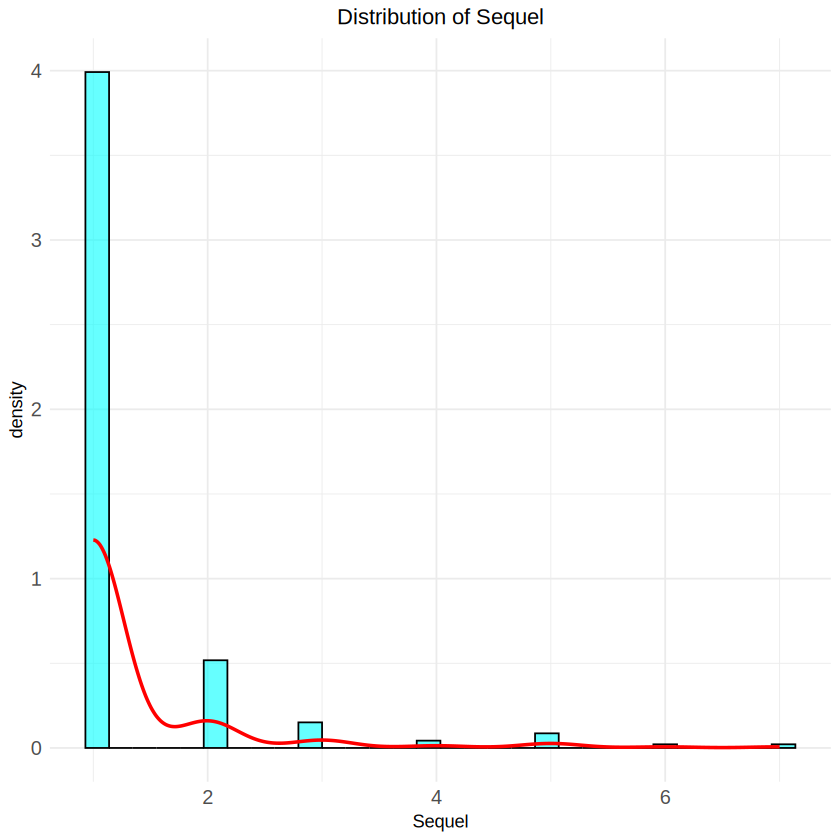

In [46]:
ggplot(cleaned_df, aes(x = Sequel)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Sequel") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

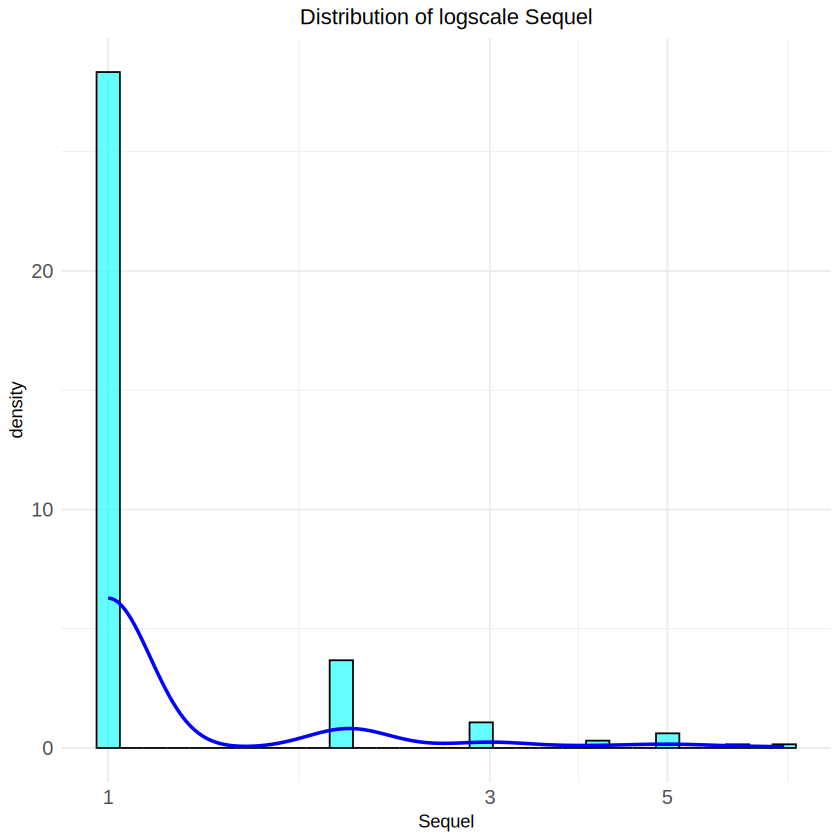

In [47]:
ggplot(cleaned_df, aes(x = Sequel)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale Sequel") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  -2"


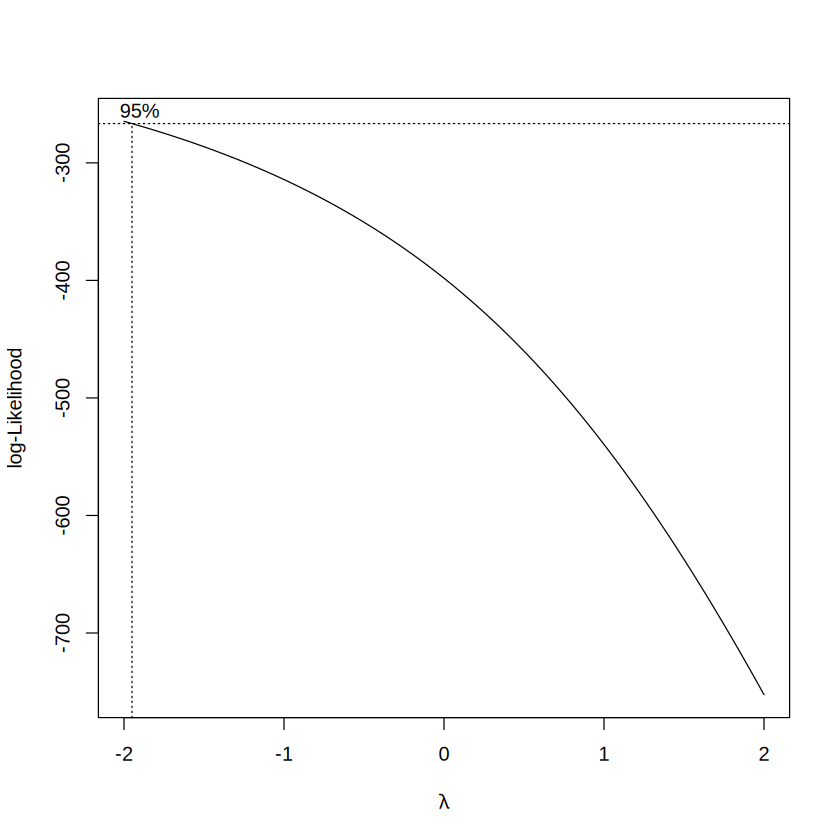

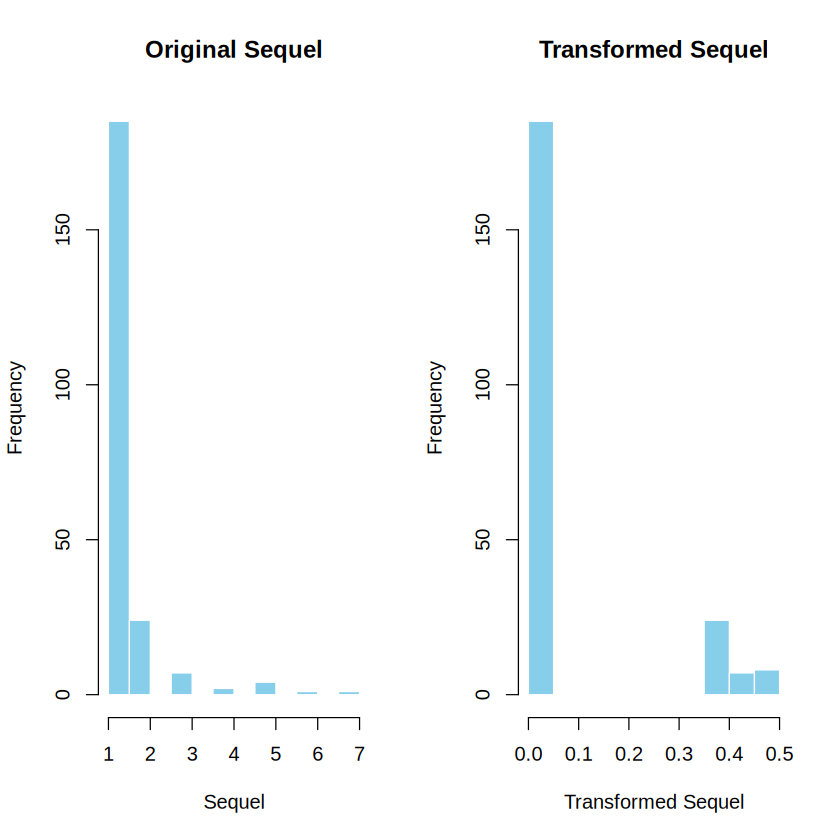

In [48]:
response_variable <- cleaned_df$Sequel 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Sequel", xlab = "Sequel", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Sequel", xlab = "Transformed Sequel", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Phân tích biến `Sentiment`

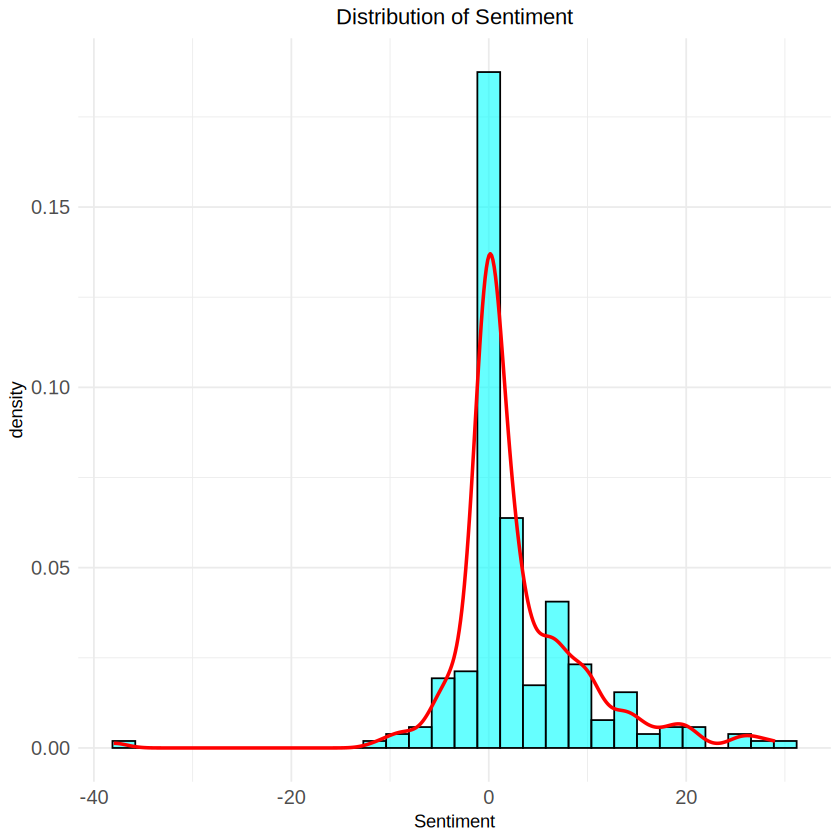

In [49]:
ggplot(cleaned_df, aes(x = Sentiment)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Sentiment") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 117 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 117 rows containing non-finite outside the scale range
(`stat_density()`).”


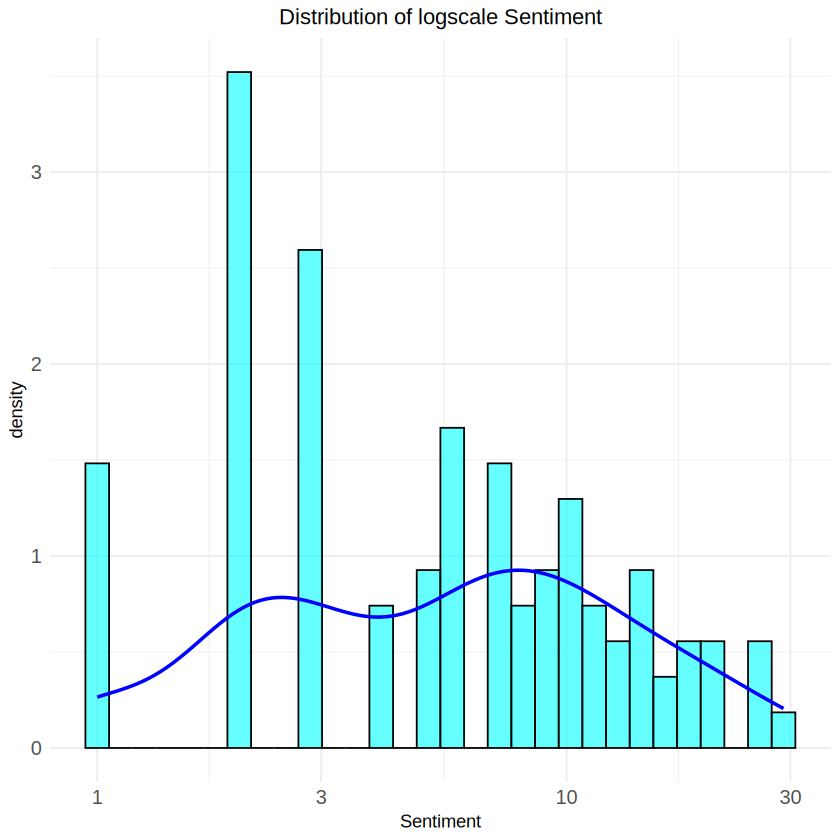

In [50]:
ggplot(cleaned_df, aes(x = Sentiment)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale Sentiment") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  1.11111111111111"


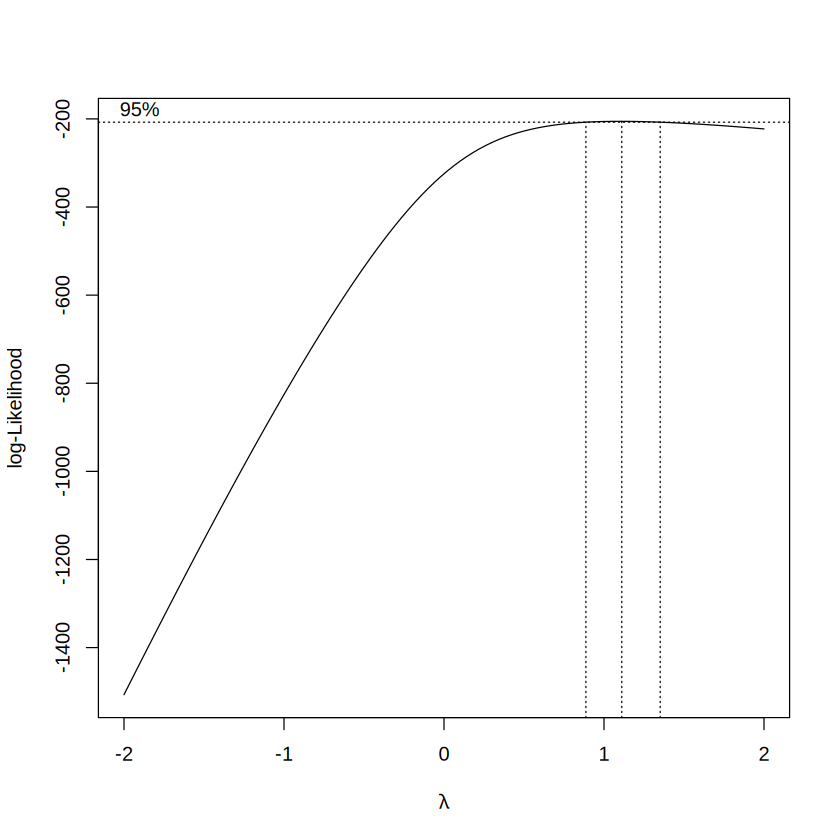

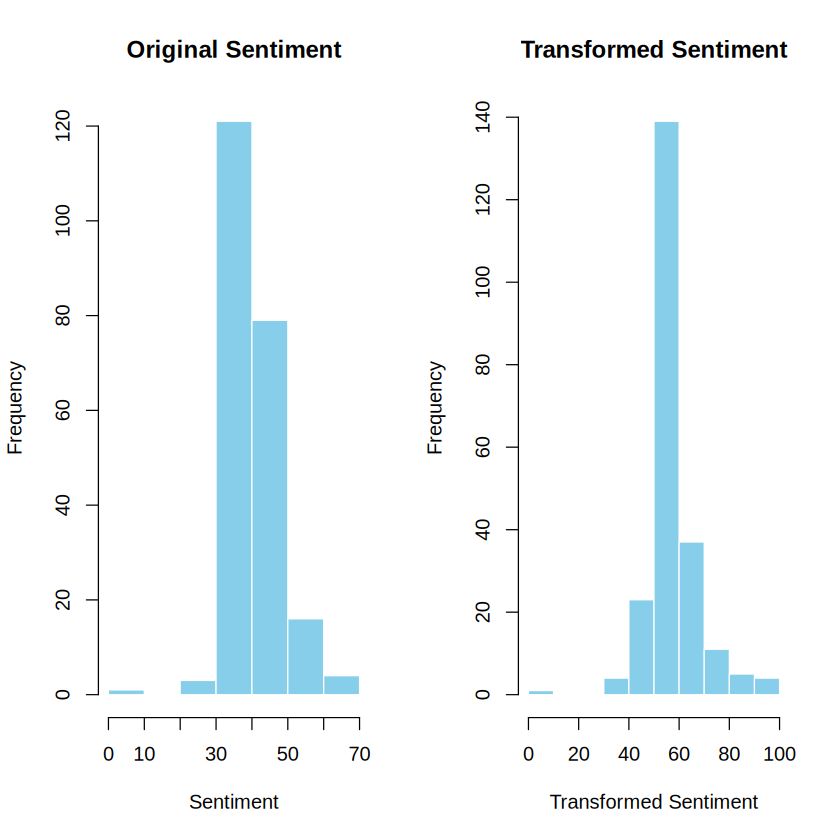

In [52]:
response_variable <- cleaned_df$Sentiment 

shift_value <- abs(min(response_variable)) + 1
response_variable <- response_variable + shift_value

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Sentiment", xlab = "Sentiment", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Sentiment", xlab = "Transformed Sentiment", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Phân tích biến `Views`

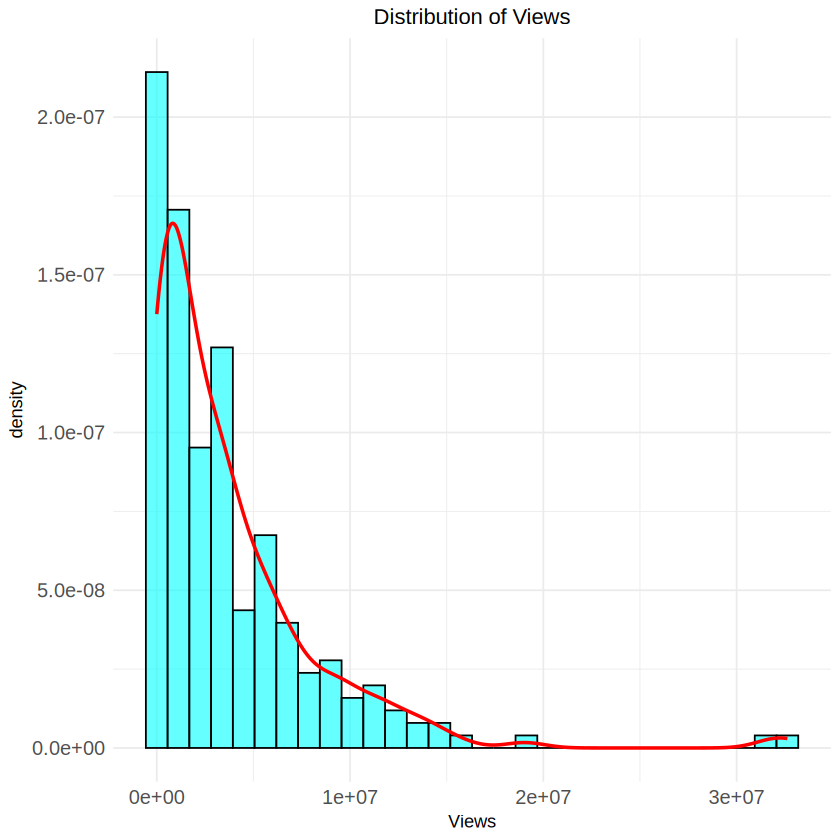

In [53]:
ggplot(cleaned_df, aes(x = Views)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Views") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

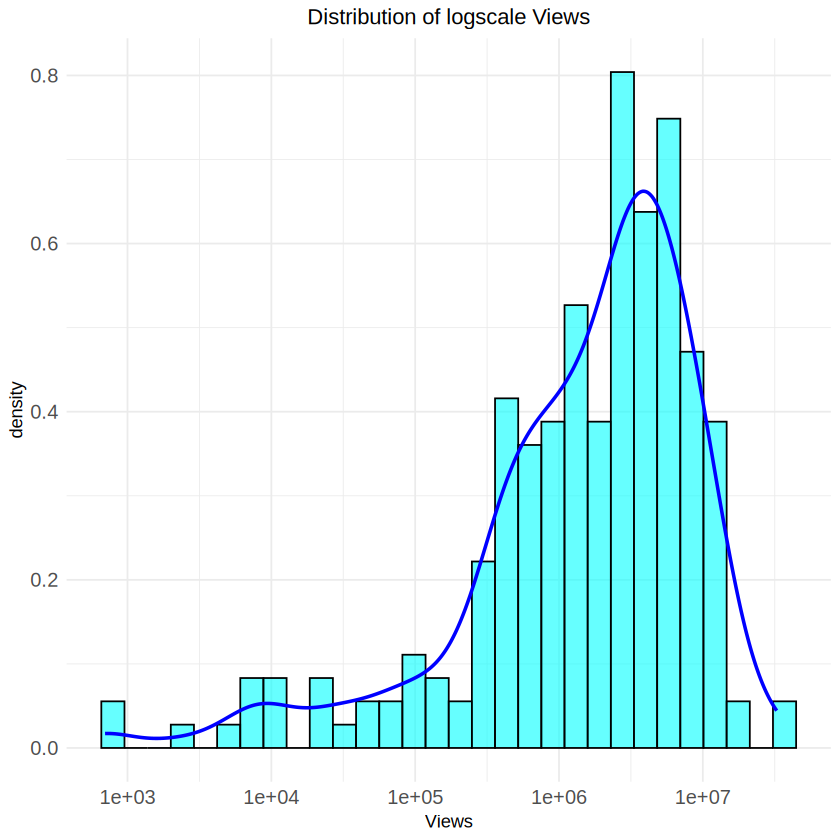

In [54]:
ggplot(cleaned_df, aes(x = Views)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale Views") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.262626262626263"


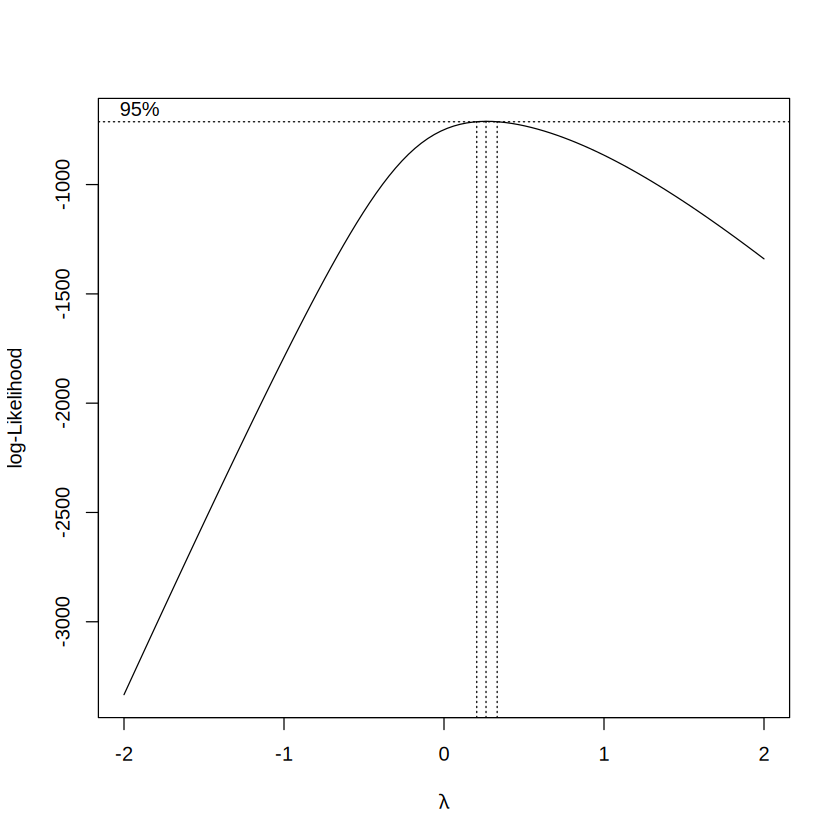

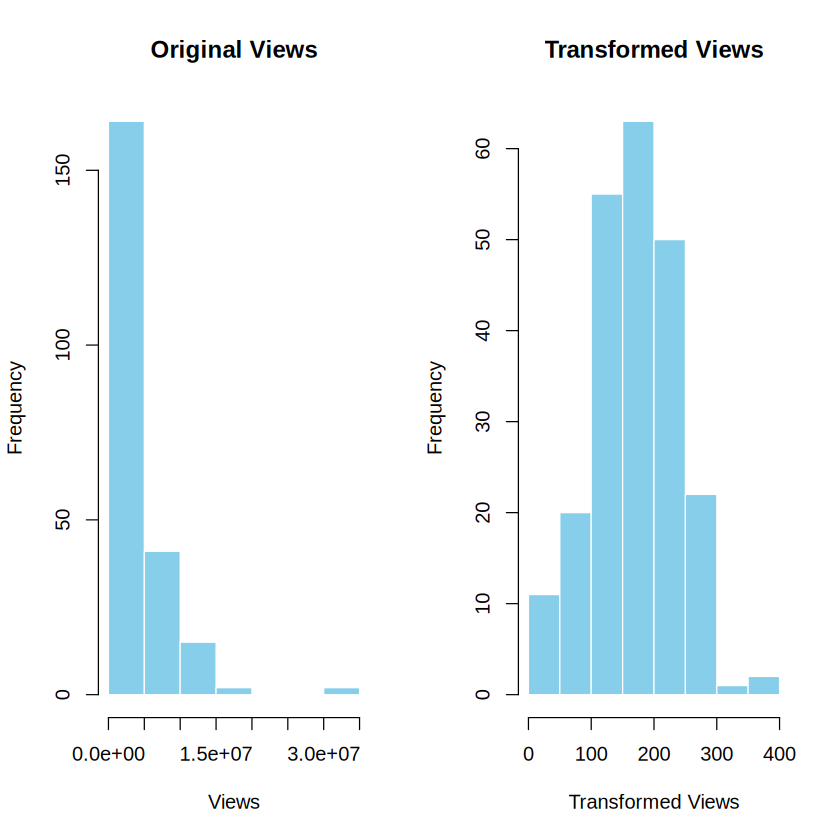

In [55]:
response_variable <- cleaned_df$Views 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Views", xlab = "Views", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Views", xlab = "Transformed Views", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Phân tích biến `Likes`

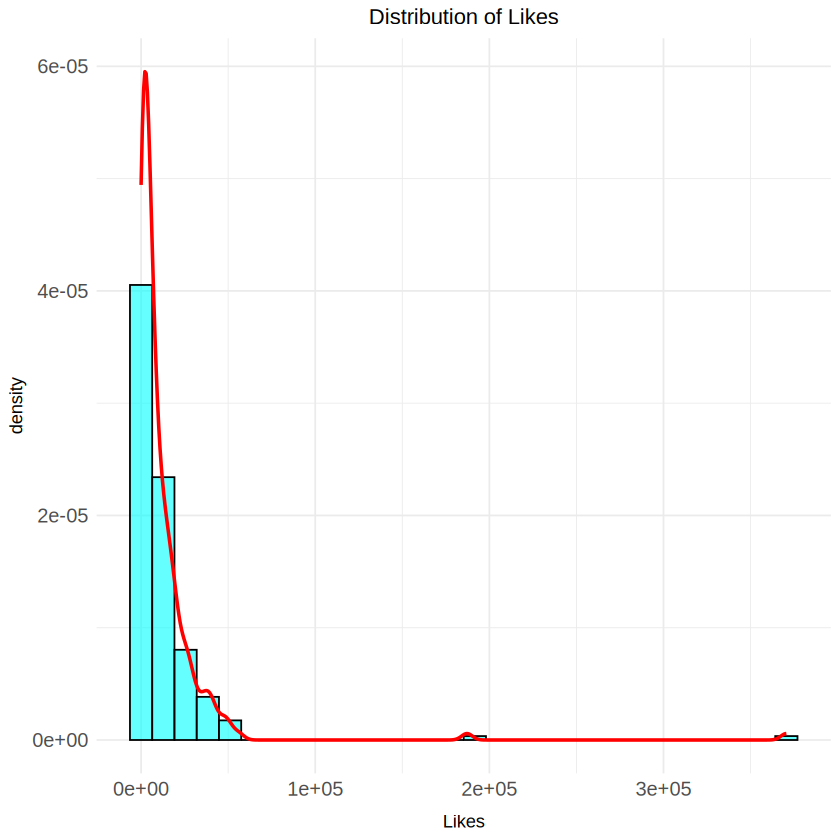

In [56]:
ggplot(cleaned_df, aes(x = Likes)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Likes") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

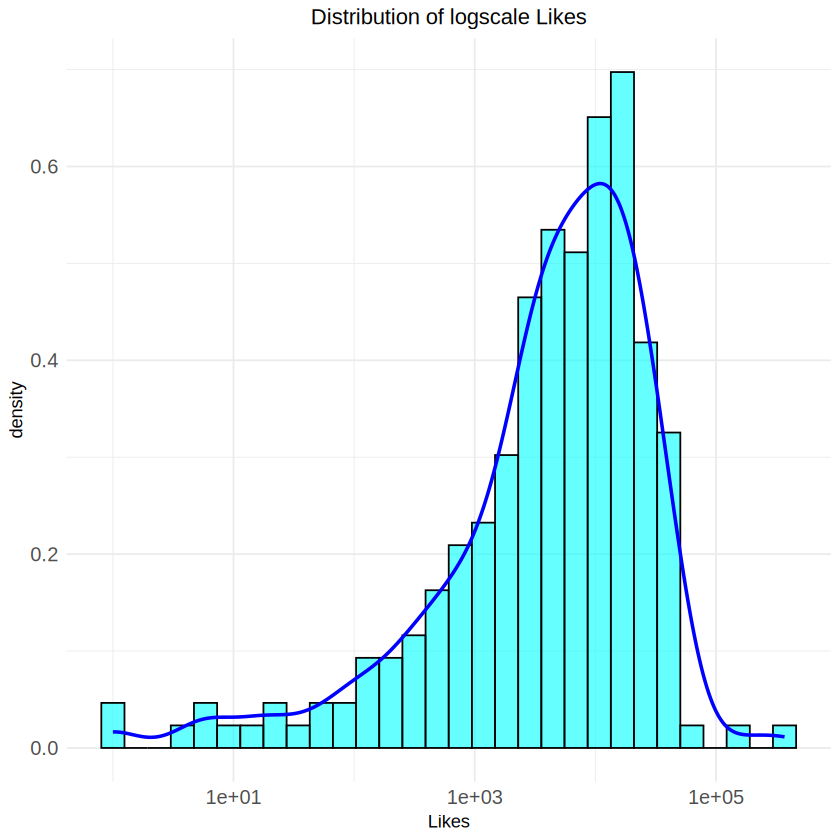

In [57]:
ggplot(cleaned_df, aes(x = Likes)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale Likes") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.222222222222222"


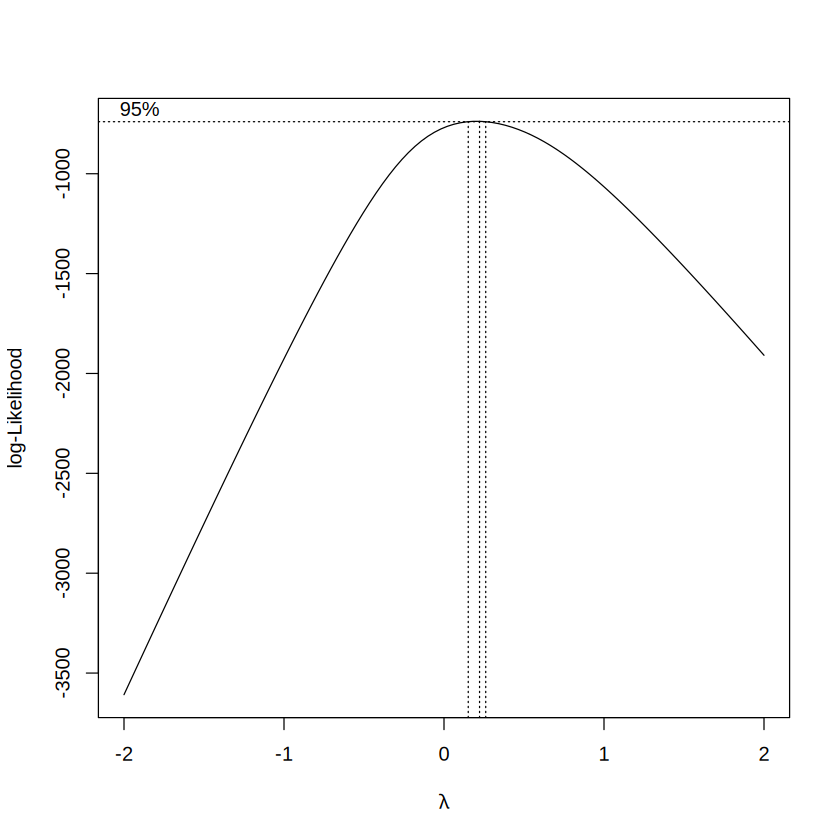

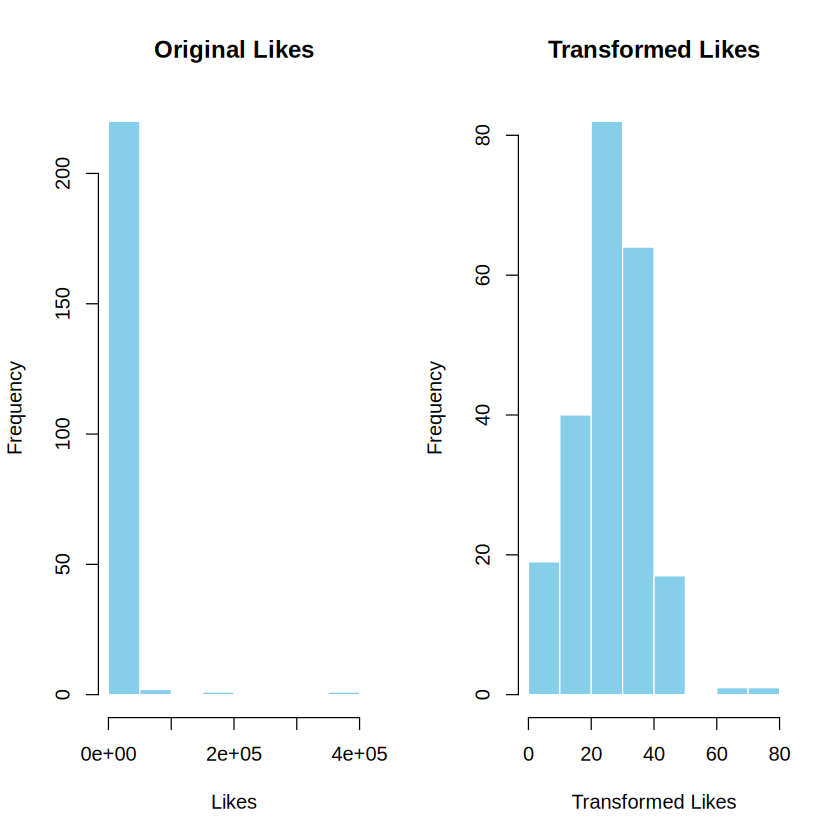

In [58]:
response_variable <- cleaned_df$Likes 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Likes", xlab = "Likes", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Likes", xlab = "Transformed Likes", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Phân tích biến `Gross`

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


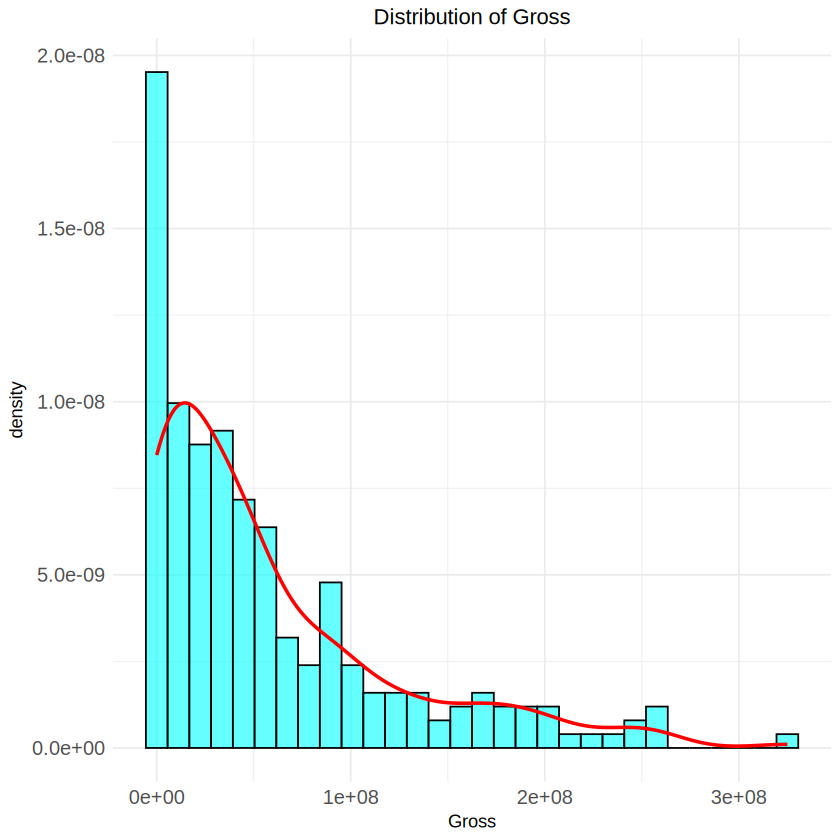

In [37]:
ggplot(cleaned_df, aes(x = Gross)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Gross") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**:
- Nhìn vào biểu đồ, ta thấy phân phối của biến `Gross` bị lệch phải.

Ta thử sử dụng log-transform nó.

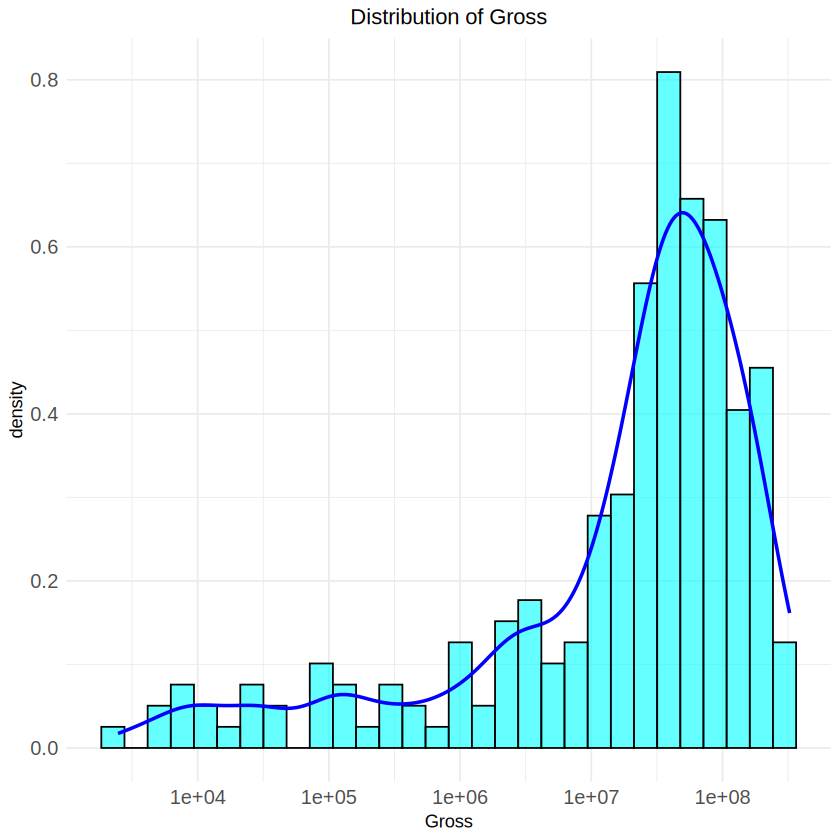

In [38]:
ggplot(cleaned_df, aes(x = Gross)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of logscale Gross") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

Ta nhận thấy sau khi sử dụng log-transform, dữ liệu bị lệch trái. Do đó, ta thử sử dụng box-cox.

[1] "Optimal lambda:  0.303030303030303"


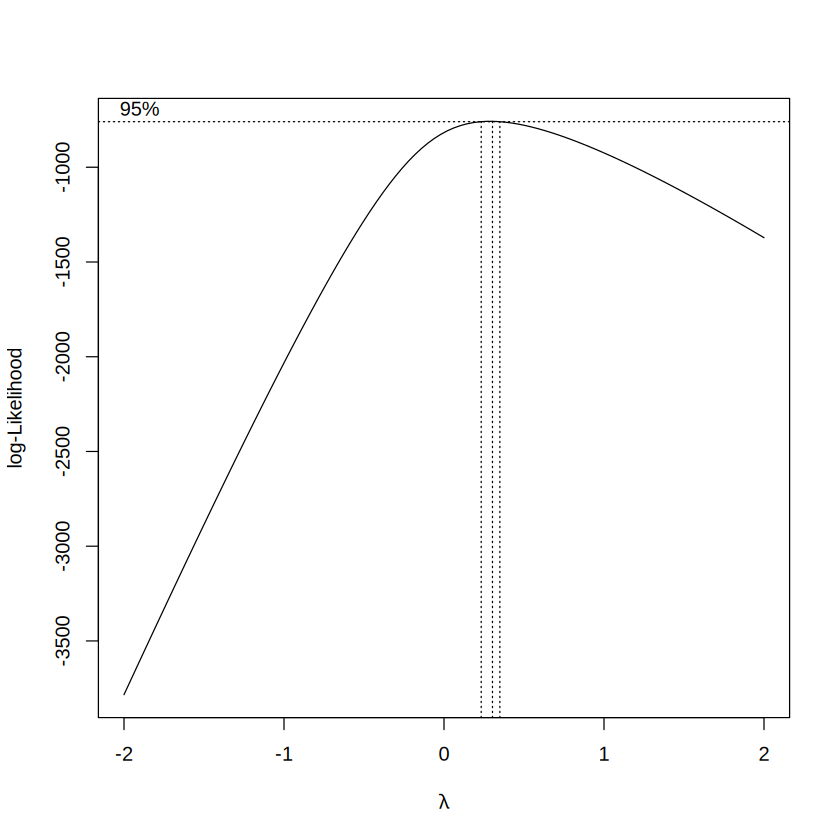

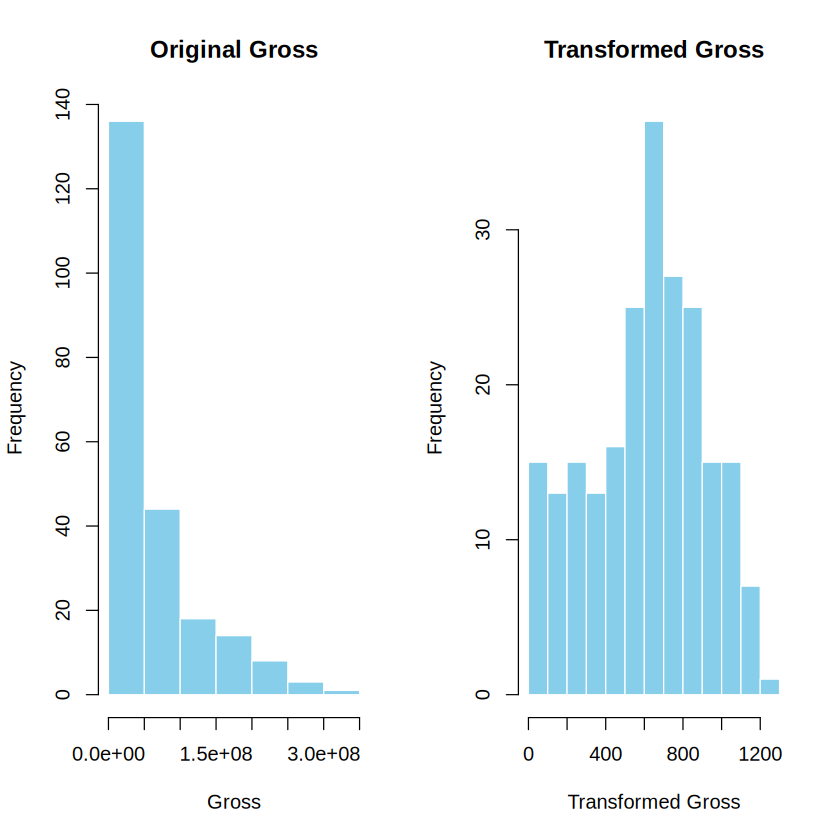

In [39]:
response_variable <- cleaned_df$Gross 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Gross", xlab = "Gross", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Gross", xlab = "Transformed Gross", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

Ta có được giá trị lambda tối ưu là 0.33 và sử dụng giá trị này để biến đổi biến `Gross`. Biểu đồ histogram phía bên dưới thể hiện phân phối của biến này trước và sau khi biến đổi. Dễ dàng thấy được, sau khi biến đổi, biến này đã tương đối chuẩn hơn.

### Phân tích biến `AggregateFollowers`

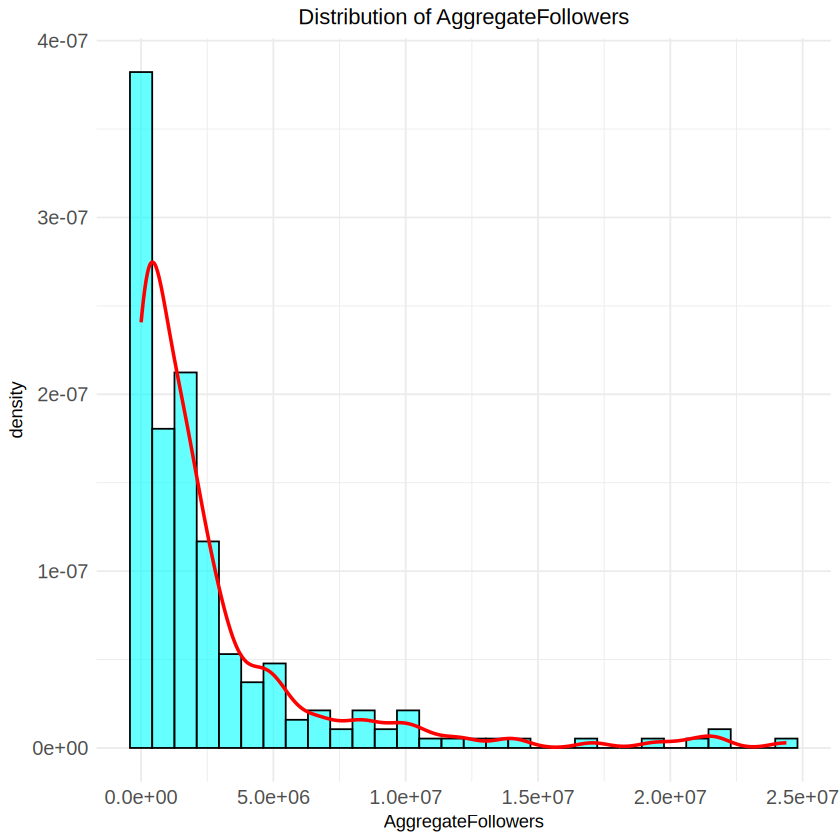

In [40]:
ggplot(cleaned_df, aes(x = AggregateFollowers)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of AggregateFollowers") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**
- Phân phối của biến `AggregateFollowers` bị lệch trái.

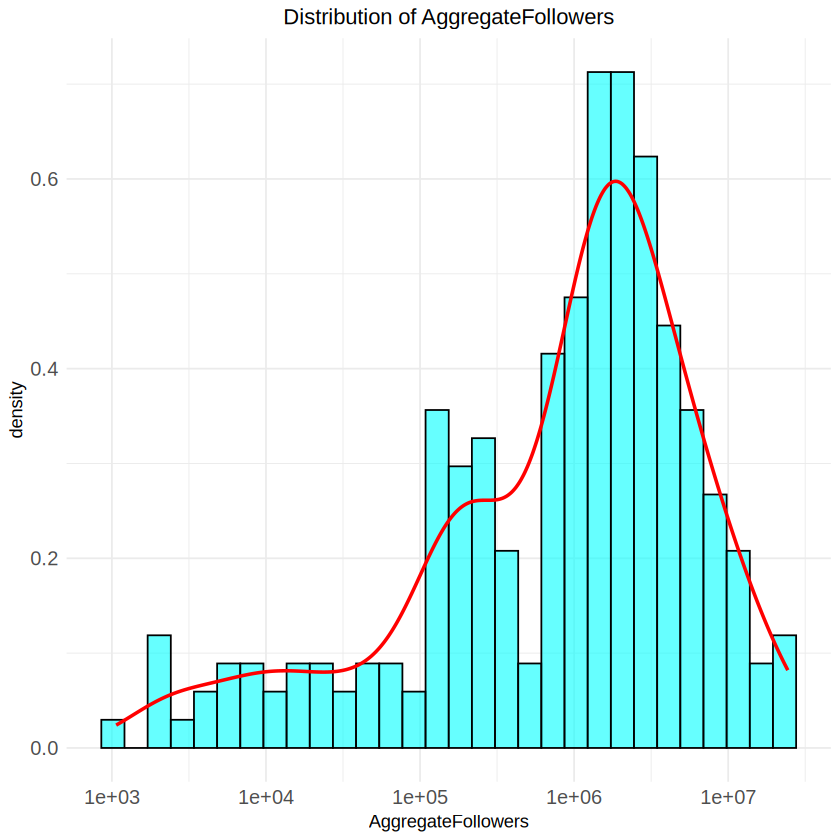

In [41]:
ggplot(cleaned_df, aes(x = AggregateFollowers)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  scale_x_log10(oob = scales::squish_infinite) +  # Apply log scale to the x-axis
  ggtitle("Distribution of AggregateFollowers") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**
- Khi dùng log-scale, phân phối của biến `AggregateFollowers` đã xấp xỉ chuẩn hơn.
- Ta có thể dùng box-cox để biến đổi dữ liệu nhờ vào việc tìm lambda tối ưu.

[1] "Optimal lambda:  0.181818181818182"


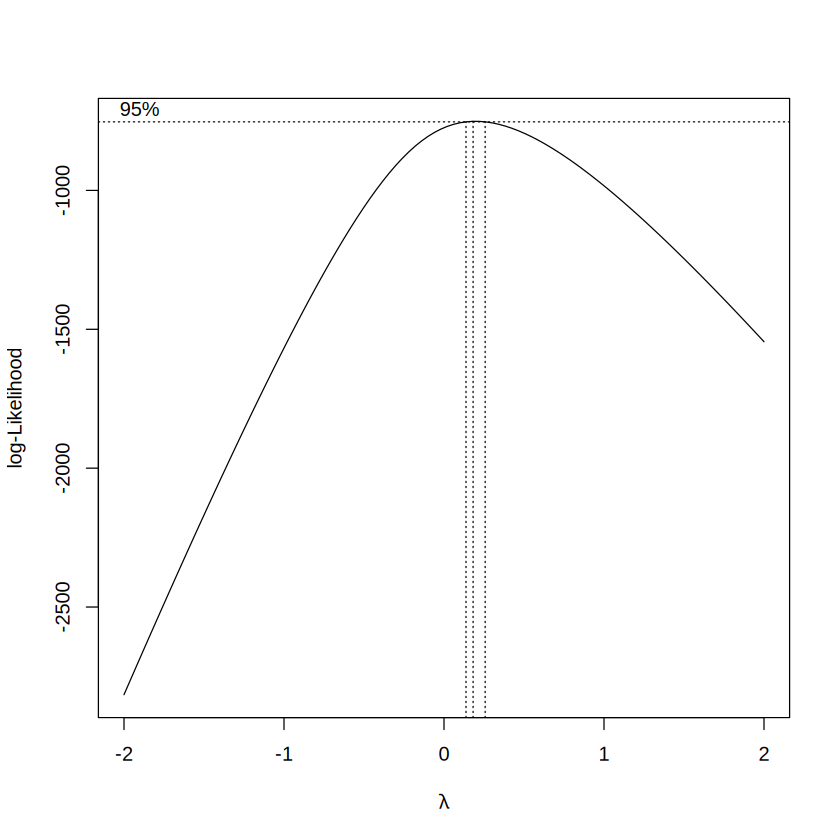

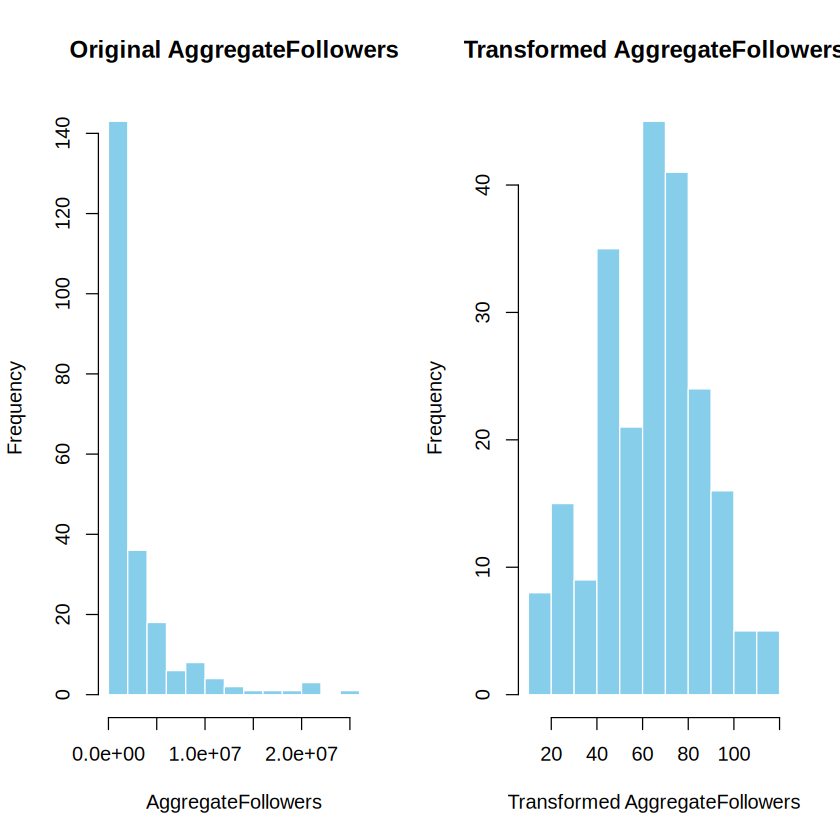

In [42]:
response_variable <- cleaned_df$AggregateFollowers

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original AggregateFollowers", xlab = "AggregateFollowers", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed AggregateFollowers", xlab = "Transformed AggregateFollowers", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

**Nhận xét**:
- Dựa vào biểu đồ, ta thấy sau khi sử dụng log-transform, biến `AggregateFollowers` đã tương đối chuẩn hơn.

## Mô hình hóa

### Xử lý đa cộng tuyến

In [ ]:
# Một số việc tiền xử lý trước: chuyển đổi sang dataframe
csm_df <- as.data.frame(csm_df)
str(csm_df)

In [ ]:
cor_matrix <- round(cor(csm_df), 2)
cor_matrix

In [ ]:
threshold <- 0.7
high_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if(abs(cor_matrix[i, j]) > threshold) {
      high_cor_pairs <- rbind(high_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(high_cor_pairs)

Nhận xét: Một số cặp có khả năng đa cộng tuyến cao
- `Likes` và `Dislikes`
- `Views` và `Comments`
- `Likes` và `Comments`
- `Gross` và `Budget`

In [ ]:
threshold <- 0

neg_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if(cor_matrix[i, j] < threshold) {
      neg_cor_pairs <- rbind(neg_cor_pairs, 
                             data.frame(Var1 = rownames(cor_matrix)[i], 
                                        Var2 = colnames(cor_matrix)[j], 
                                        value = cor_matrix[i, j]))
    }
  }
}

print(neg_cor_pairs)

In [ ]:
model <- lm(Gross ~ ., data = csm_df)
vif_values <- vif(model)
print(vif_values)

In [ ]:
threshold <- 3
while (any(vif_values > threshold)) {
  highest_vif <- which.max(vif_values)
  variable_to_remove <- names(vif_values)[highest_vif]
  formula <- as.formula(paste("Gross ~ . -", variable_to_remove))
  model <- update(model, formula)
  vif_values <- vif(model)
}

In [ ]:
print(vif_values)
summary(model)

In [ ]:
cleaned_df <- csm_df[, names((vif_values))]
cleaned_df$Gross <- csm_df$Gross
head(cleaned_df)

In [ ]:
# Trực quan phân phối
plot(cleaned_df)

In [ ]:
round(cor(cleaned_df), 2)

### Khảo sát ngoại lai

In [ ]:
# Ở đây sử dụng IQR để loại bỏ ngoại lai
Q1 <- quantile(cleaned_df$'Gross', 0.25)
Q3 <- quantile(cleaned_df$'Gross', 0.75)
IQR <- Q3 - Q1
lower_bound <- Q1 - 1.5 * IQR
upper_bound <- Q3 + 1.5 * IQR
outliers <- which(cleaned_df$'Gross' < lower_bound | cleaned_df$'Gross' > upper_bound)
print(outliers)

lower_bound <- Q1 - 3 * IQR
upper_bound <- Q3 + 3 * IQR
extreme_outliers <- which(cleaned_df$'Gross' < lower_bound | cleaned_df$'Gross' > upper_bound)
print(extreme_outliers)

In [ ]:
cleaned_df <- cleaned_df[-extreme_outliers,]

### Phân chia tập dữ liệu

Ở đây, ta phân chia dữ liệu thành hai tập: train (80%) và test (20%).

In [ ]:
csm_df <- bc_transform(cleaned_df)

In [ ]:
split_ratio <- 0.8
split_index <- floor(nrow(csm_df) * split_ratio)

train = csm_df[1:split_index,]
test = csm_df[(split_index + 1):nrow(csm_df),]

In [ ]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

In [ ]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

In [ ]:
# xem một số quan trắc của tập train
str(train)

### Khảo sát sự tương quan giữa các biến

In [49]:
# round(cor(train[, c(1:13)]), 2)
round(cor(train), 2)

,Ratings,Budget,Screens,Sequel,Sentiment,Views,Likes,AggregateFollowers,Gross
Ratings,1.00,0.27,-0.01,0.06,0.17,0.05,0.12,0.12,0.24
Budget,0.27,1.00,0.53,0.39,0.12,0.21,0.24,0.23,0.73
Screens,-0.01,0.53,1.00,0.19,-0.04,0.23,0.29,0.21,0.64
Sequel,0.06,0.39,0.19,1.00,-0.04,-0.03,0.00,0.18,0.34
Sentiment,0.17,0.12,-0.04,-0.04,1.00,0.15,0.16,-0.05,0.08
Views,0.05,0.21,0.23,-0.03,0.15,1.00,0.92,0.31,0.31
Likes,0.12,0.24,0.29,0.00,0.16,0.92,1.00,0.32,0.38
AggregateFollowers,0.12,0.23,0.21,0.18,-0.05,0.31,0.32,1.00,0.27
Gross,0.24,0.73,0.64,0.34,0.08,0.31,0.38,0.27,1.00


In [50]:
cor.mtest <- function(mat, ...) {
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat<- matrix(NA, n, n)
    diag(p.mat) <- 0
    for (i in 1:(n - 1)) {
        for (j in (i + 1):n) {
            tmp <- cor.test(mat[, i], mat[, j], ...)
            p.mat[i, j] <- p.mat[j, i] <- tmp$p.value
        }
    }
  colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
  p.mat
}

p.mat <- cor.mtest(train)

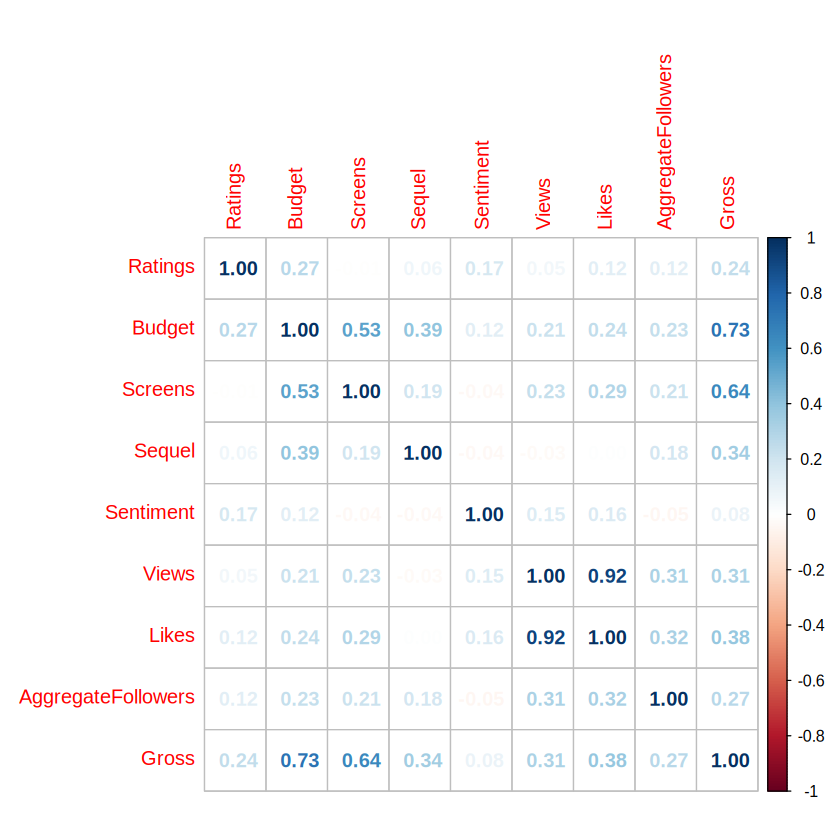

In [52]:
library(corrplot)
corrplot(round(cor(train), 2), method="number")

Một số nhận xét:
- Biến `Ratings` và biến `AggregateFollowers` có tương quan với biến `Gross` cao, lần lượt 0.21 và 0.27
- Các biến `Dislikes` và `Comments` có tương quan với biến `Gross` cao hơn hai biến còn lại, 0.42 và 0.41
- Biến `Comments` có tương quan thuận, mạnh với biến `Dislikes`, 0.87
- Biến `Comments` có tương quan thuận, yếu với biến `Ratings`, 0.13
- Biến `Comments` có tương quan thuận, vừa với biến `AggregateFollowers`, 0.23
- Biến `Dislikes` có tương quan nghịch, yếu với biến `Ratings`, -0.07

### Xây dựng mô hình đầy đủ

In [53]:
str(train)

'data.frame':	179 obs. of  9 variables:
 $ Ratings           : num  2.23 2.4 2.2 2.23 1.81 ...
 $ Budget            : num  99.6 168.3 149.3 197.9 96.8 ...
 $ Screens           : num  5.71 20.28 19.58 20.53 18.53 ...
 $ Sequel            : num  0 0.743 0 0.743 0.743 ...
 $ Sentiment         : num  5.4 5.51 5.4 5.4 5.4 ...
 $ Views             : num  95.5 66.1 57.5 62.6 94.7 ...
 $ Likes             : num  22 20.5 10.9 18.8 27.8 ...
 $ AggregateFollowers: num  76.1 126 63.5 65.8 85.3 ...
 $ Gross             : num  26 222 152 196 135 ...


In [54]:
full.lm <- lm(Gross ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = Gross ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-136.99  -18.79    3.70   22.97   84.15 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -60.21332   62.87576  -0.958   0.3396    
Ratings             21.80737   12.55030   1.738   0.0841 .  
Budget               0.65118    0.08619   7.555 2.46e-12 ***
Screens              2.89668    0.49989   5.795 3.25e-08 ***
Sequel              11.31840    6.07145   1.864   0.0640 .  
Sentiment           -0.21697   10.96256  -0.020   0.9842    
Views               -0.29107    0.25634  -1.136   0.2578    
Likes                1.79341    0.75762   2.367   0.0190 *  
AggregateFollowers   0.03477    0.09788   0.355   0.7228    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.9 on 170 degrees of freedom
Multiple R-squared:  0.6614,	Adjusted R-squared:  0.6455 
F-statistic: 41.51 on 8 and 170 DF,  p-value: < 2.2e-1

Nhận xét:

### Lựa chọn model tốt nhất

Với số lượng lớn các yếu tố dự đoán, điều quan trọng là phải giảm thiểu mô hình bằng cách chỉ bao gồm các yếu tố dự đoán hữu ích. Có tất cả 6 yếu tố dự đoán trong tập dữ liệu, nghĩ là có thể có $2^{3}$ mô hình hồi quy. Để chọn mô hình một cách hiệu quả, việc lựa chọn lùi được thực hiện bằng sử dụng step function. Phương pháp này lặp lại các quy trình để giảm thiểu Akaike’s Information Criteria (AIC) và Bayesian Information Criteria (BIC). Lựa chọn mô hình ngược so với lựa chọn tiến vì nó loại bỏ khả năng một yếu tố dự đoán mới được chọn có khả năng tương tự hoặc nhiều hơn để giải thích các phần của phản hồi đã được giải thích bởi một yếu tố dự đoán khác có trong mô hình.

In [55]:
# Mô hình chặn dưới
model.lb <- lm(Gross ~ 1, data = train) 

In [56]:
# Mô hình chặn trên
model.up <- full.lm

In [57]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = Gross ~ Ratings + Budget + Screens + Sequel + Likes, 
    data = train)

Coefficients:
(Intercept)      Ratings       Budget      Screens       Sequel        Likes  
   -72.5562      24.4101       0.6444       2.9817      11.9940       1.0309  


In [59]:
csm_models<- regsubsets(Gross ~  Ratings + Budget + Screens + Sequel + Likes, data = train)
summary.csm<-summary(csm_models)

In [60]:
# Lựa chọn mô hình tốt nhất từ reg subsets 
summary.csm$which

,(Intercept),Ratings,Budget,Screens,Sequel,Likes
1,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE
2,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE
3,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE
4,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


Tiêu chí chọn mô hình tốt nhất 1: mô hình với $R^2$ lớn (tương ứng với MSE nhỏ)

In [61]:
summary.csm$rsq

[1] 0.5315931 0.6189967 0.6434192 0.6507743 0.6586832

Tiêu chí chọn mô hình tốt nhất 2: mô hình với $R^2$ hiệu chỉnh lớn

In [62]:
# model with largest adjusted R^2 
summary.csm$adjr2

[1] 0.5289468 0.6146671 0.6373064 0.6427461 0.6488185

Tiêu chí chọn mô hình tốt nhất 3: mô hình với Mallow's Cp nhỏ

In [63]:
# model with smallest Mallow's Cp
summary.csm$cp

[1] 62.416914 20.115499  9.736717  8.008714  6.000000

#### Chọn mô hình tốt nhất dựa trên BIC

In [64]:
# Tiêu chí chọn mô hình tốt nhất 4: mô hình với BIC nhỏ
summary.csm$bic

[1] -125.3820 -157.1634 -163.8342 -162.3776 -161.2907

In [65]:
best_model_index <- which.min(summary.csm$bic)
best_model <- summary.csm$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

(Intercept)     Ratings      Budget     Screens      Sequel       Likes 
       TRUE       FALSE        TRUE        TRUE       FALSE        TRUE 
[1] "Budget"  "Screens" "Likes"  


In [66]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("Gross ~", paste(best_vars, collapse = " + "))
best_model_csm <- lm(as.formula(formula_str), data=train)

In [67]:
# Tóm tắt mô hình
summary(best_model_csm)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-142.604  -17.715    1.929   22.419   87.326 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -27.97801   10.72422  -2.609 0.009870 ** 
Budget        0.75150    0.07662   9.808  < 2e-16 ***
Screens       2.78579    0.48627   5.729 4.33e-08 ***
Likes         1.02351    0.29564   3.462 0.000674 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 35.3 on 175 degrees of freedom
Multiple R-squared:  0.6434,	Adjusted R-squared:  0.6373 
F-statistic: 105.3 on 3 and 175 DF,  p-value: < 2.2e-16


Như vậy, ta thu được mô hình

```
Gross ~ -174.677 * (Intercept) + 75.062 * Ratings + 29.984 * Dislikes
```

Điều này có ý nghĩa là, biến `Gross` sẽ được giải thích thông qua hai biến `Ratings` và `Dislikes` 
- Điểm xếp hạng càng cao thì doanh thu của một bộ phim cũng cao (hợp lý theo logic thông thường).
- Số lượt chê càng cao thì doanh thu của một bộ phim cũng cao. Điều này có thể lý giải, khi một bộ phim có nhiều bình luận tiêu cực, người ta sẽ có hứng thú đi xem nó để biết tại sao nó bị chê (yếu tố tò mò).

Bây giờ, ta sẽ đi phân tích xem mô hình này có thỏa những giả định của mô hình hồi quy bội hay không?

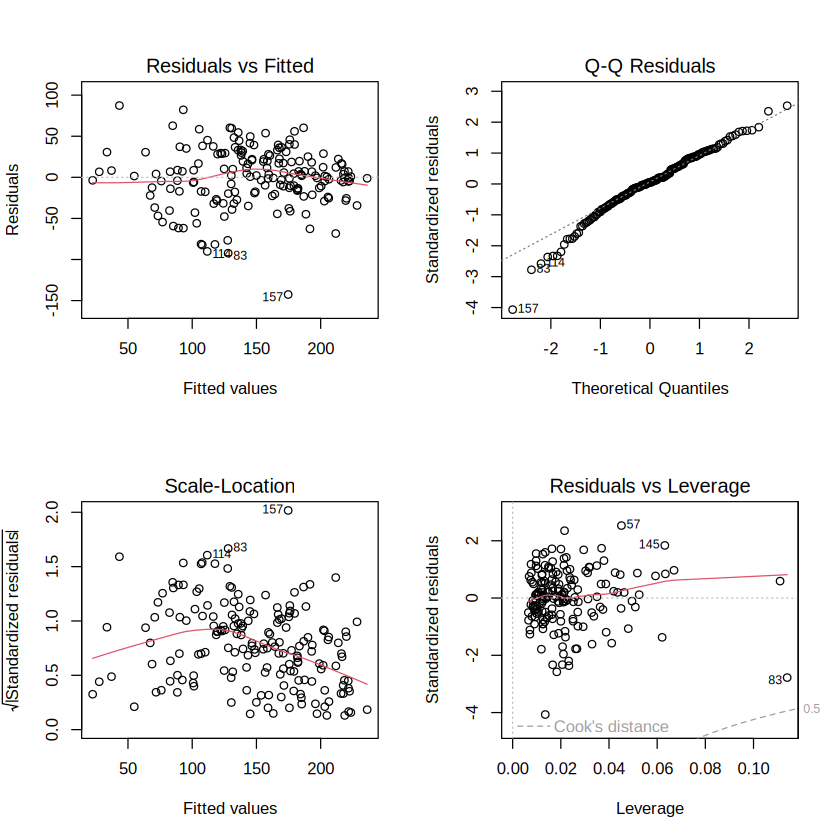

In [68]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_csm)

#### Phân tích Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

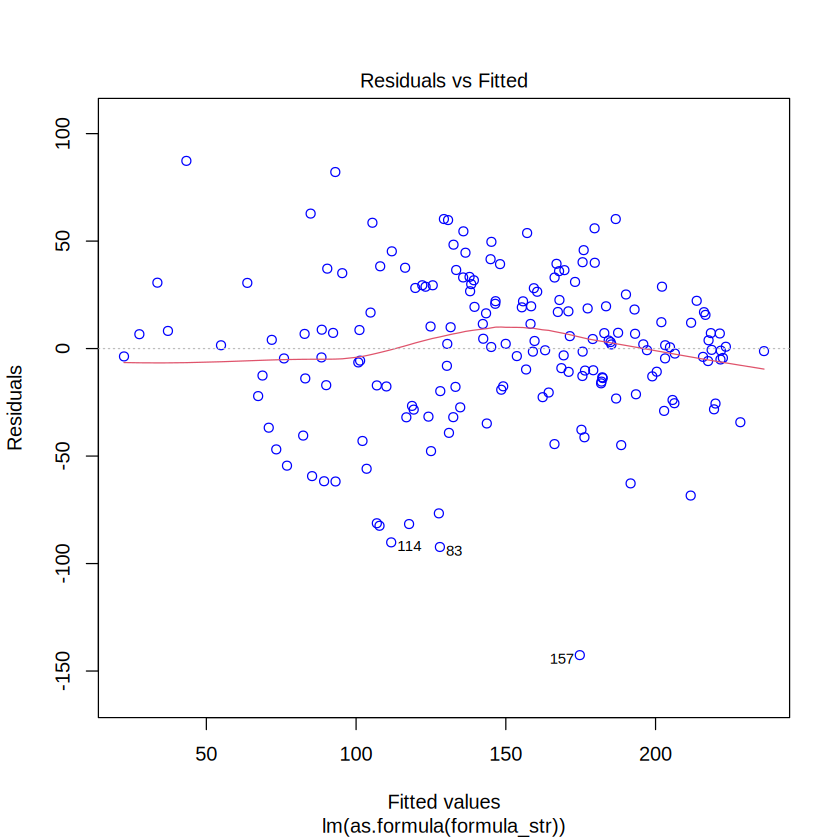

In [69]:
plot(best_model_csm, which=1, col=c("blue")) # Residuals vs Fitted Plot

Dựa trên biểu đồ này, ta thấy đường cong màu đỏ có dáng chưa gần như một đường thẳng, và các phần tử trải dọc theo đường cong này một cách tương chưa đồng đều. Điều này chứng tỏ có quan hệ phi tuyến xuất hiện trong dữ liệu.

#### Phân tích Normal Q–Q (quantile-quantile) Plot

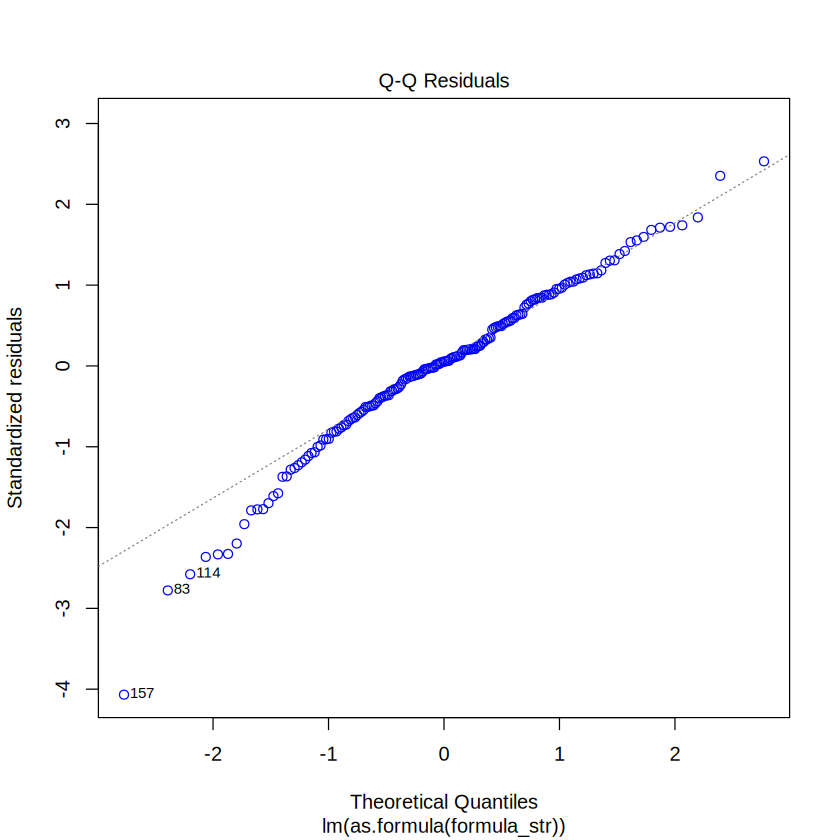

In [70]:
plot(best_model_csm, which=2, col=c("blue")) # QQ Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có phân phối chuẩn.

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.97565, p-value = 0.003158

[1] "H0 rejected: the residuals are NOT distributed normally"


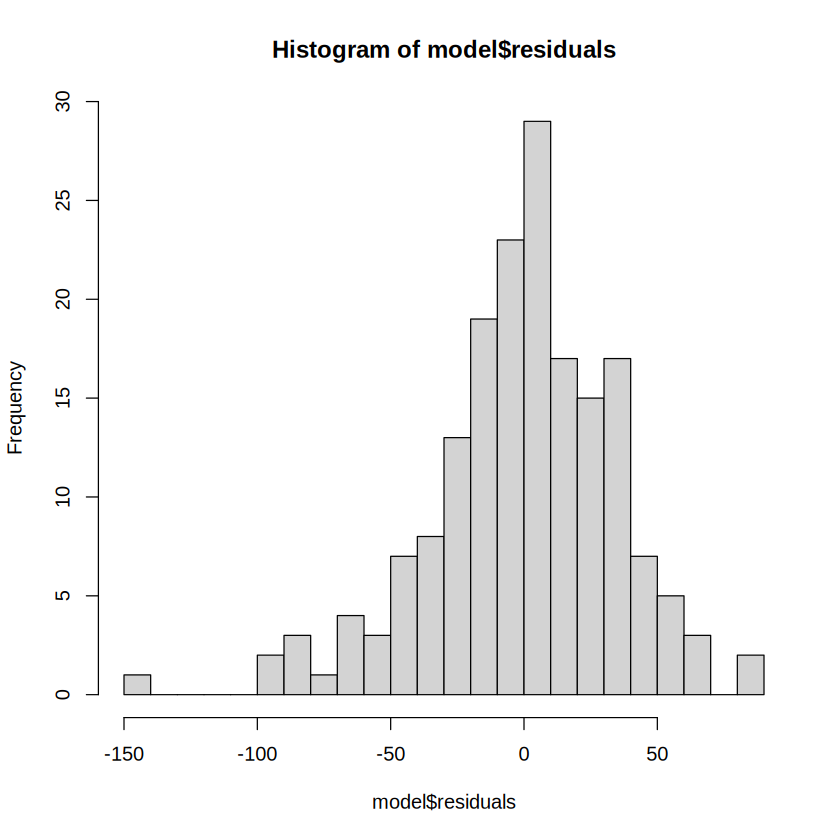

In [87]:
# Shapiro-Wilk normality test
# shapiro.test(residuals(best_model_csm))
CheckNormal(best_model_csm)

Kết quả cho thấy p-value bé hơn mức ý nghĩa alpha 0.05 nên ta có thể bác bỏ giả thhuyết H0, biến thặng dư của chúng ta không chuẩn trong một số quần thể. 

#### Phân tích Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

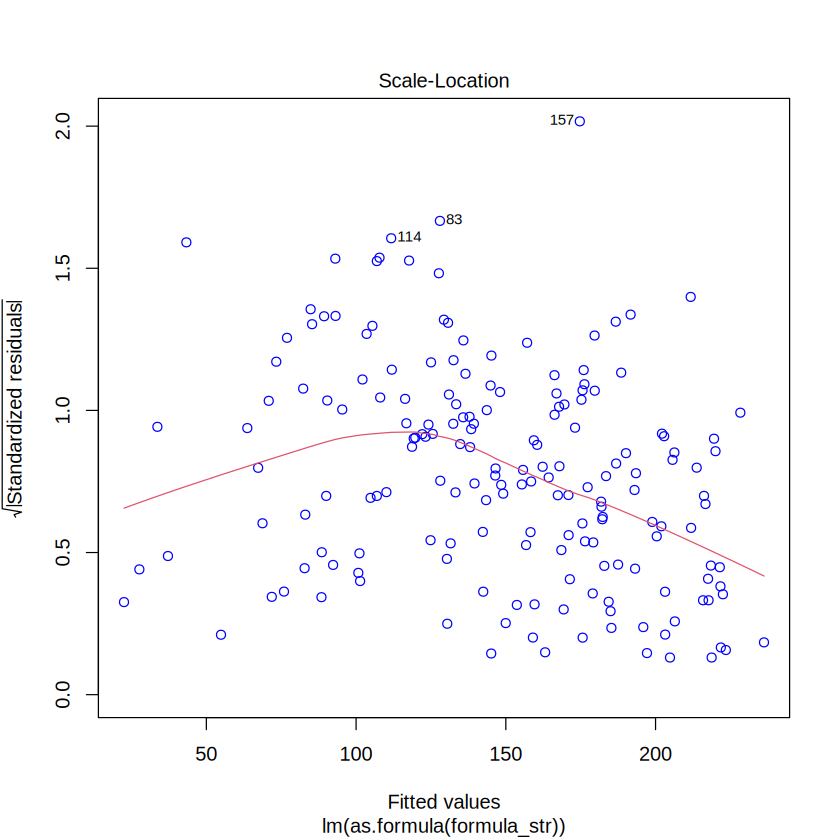

In [72]:
plot(best_model_csm, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần bị lệch về phía dưới của biểu đồ. Nghĩa là, độ phân tán của giá trị thặng dư gần không bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng dư được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên không bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic


	studentized Breusch-Pagan test

data:  model
BP = 6.8056, df = 3, p-value = 0.07836

[1] "H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)"


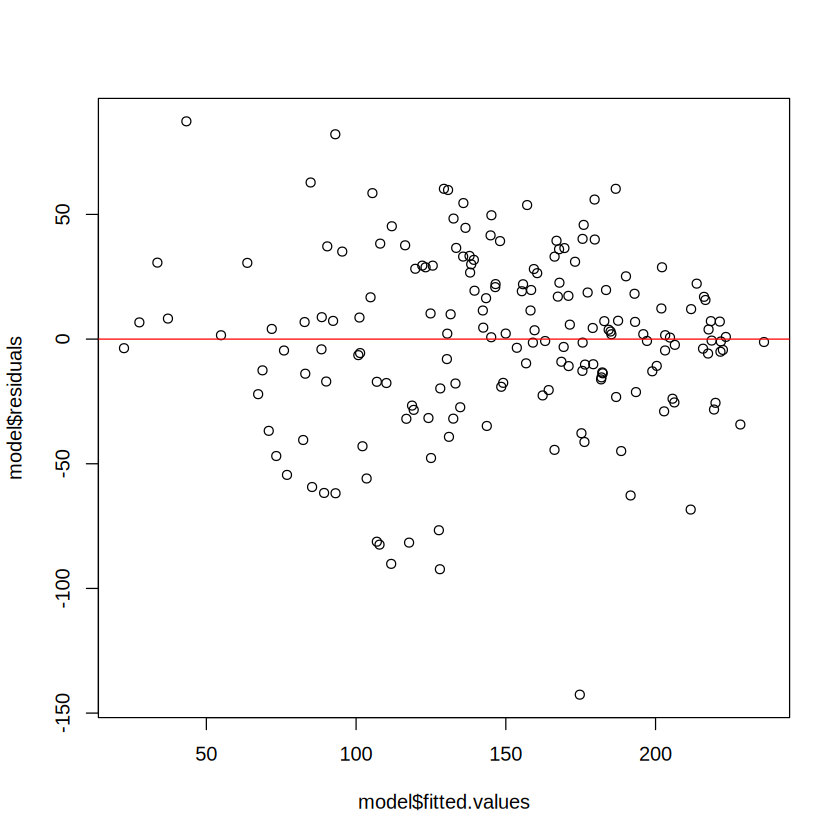

In [88]:
# Breusch-Pagan Test
# bptest(best_model_csm)
CheckHomos(best_model_csm)

Như vậy, ta thấy p-value lớn hơn múc ý nghĩa 0.05, ta chưa đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là homoscedastic

#### Phân tích Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

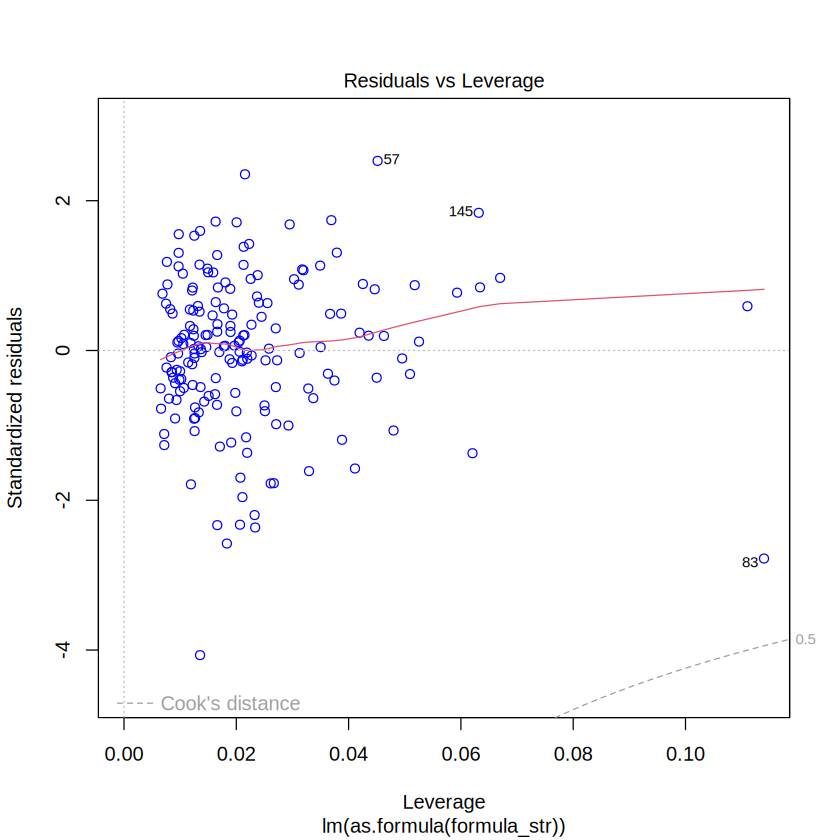

In [74]:
plot(best_model_csm, which=5, col=c("blue")) # Residuals vs Leverage

Ta nhận thấy có một số giá trị ngoại lai ở cách xa đường thằng giữa. Ta có thể xem rõ hơn thông qua histogram của Cook's Distance

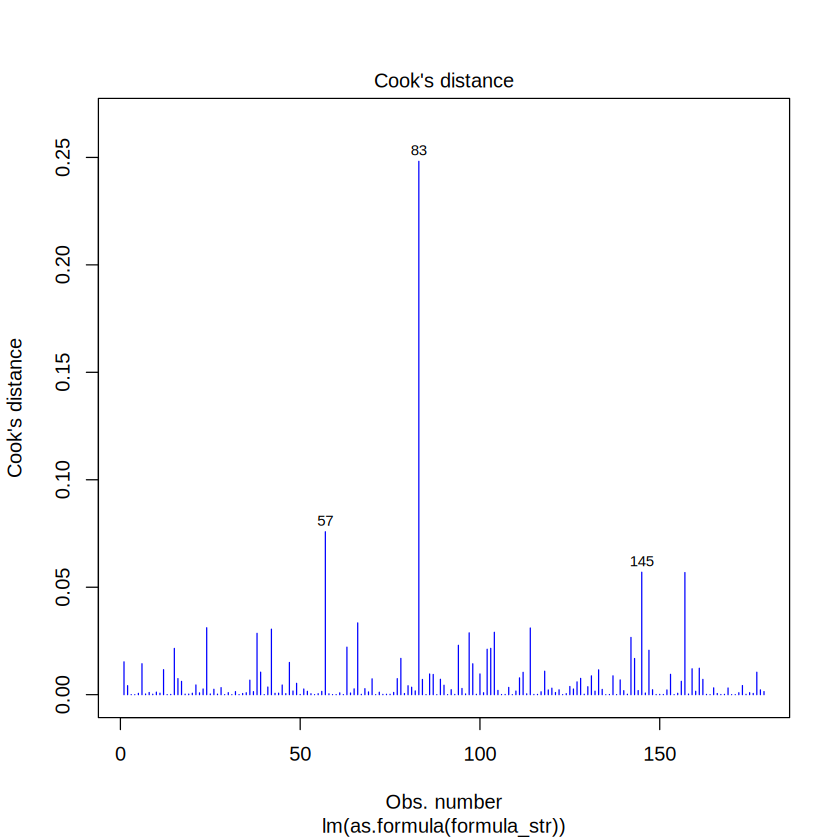

In [75]:
plot(best_model_csm, which=4, col=c("blue"))

Kết luận:
- Mô hình thu được có thể được sử dụng để đem đi dự đoán.

### Loại bỏ ngoại lai dựa trên Cook'Distance

In [76]:
# Xây dựng ngưỡng cho Cook Distance
threshold <- 4 / nrow(train)
threshold

[1] 0.02234637


Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
   Min     1Q Median     3Q    Max 
-71.07 -17.18   0.42  19.32  58.85 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -21.37468    9.25407  -2.310   0.0222 *  
Budget        0.65659    0.06692   9.811  < 2e-16 ***
Screens       3.27610    0.41667   7.863 4.99e-13 ***
Likes         1.14767    0.25277   4.540 1.09e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.76 on 162 degrees of freedom
Multiple R-squared:  0.7377,	Adjusted R-squared:  0.7329 
F-statistic: 151.9 on 3 and 162 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.98973, p-value = 0.2725

[1] "H0 failed to reject: the residuals ARE distributed normally"


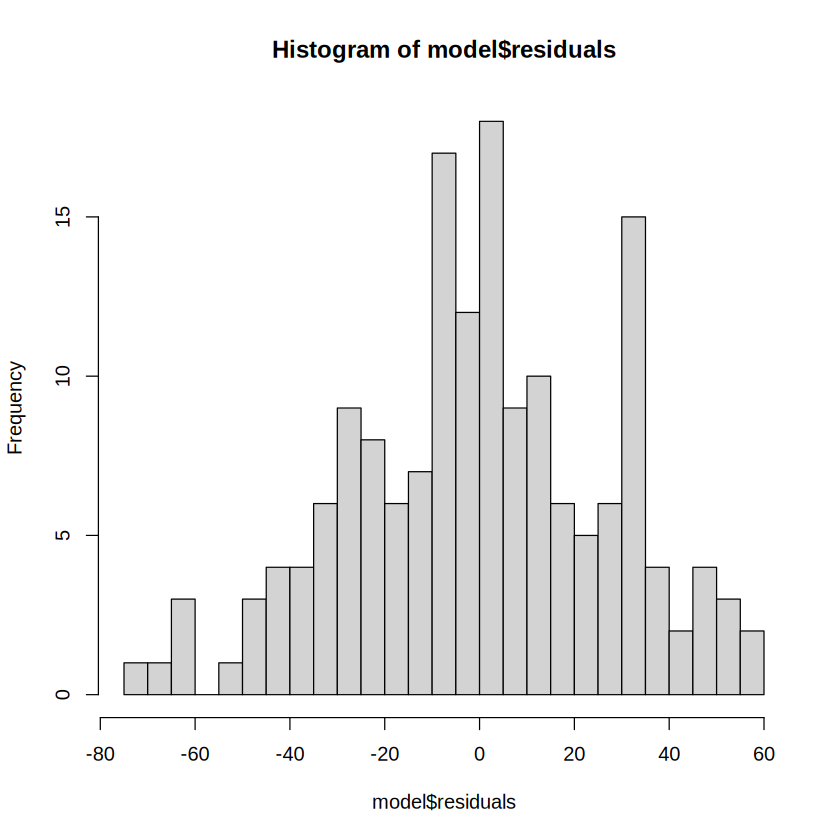


	studentized Breusch-Pagan test

data:  model
BP = 11.356, df = 3, p-value = 0.009948

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


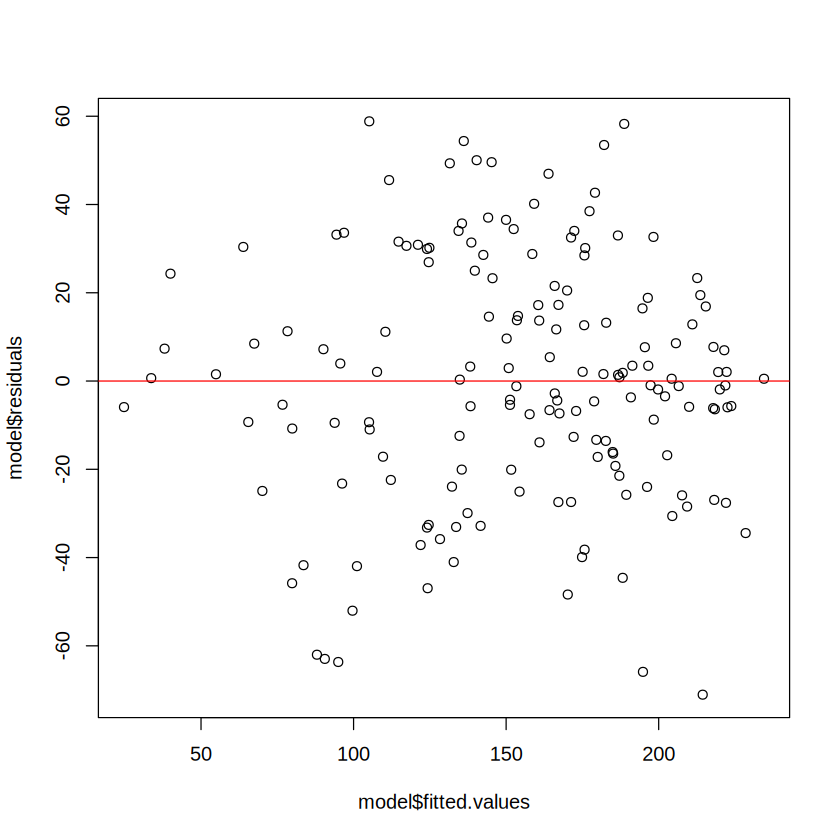

In [89]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_csm)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_csm.2 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_csm.2)

# Shapiro-Wilk normality test
# shapiro.test(residuals(best_model_csm.2))
CheckNormal(best_model_csm.2)

# Breusch-Pagan Test
# bptest(best_model_csm.2)
CheckHomos(best_model_csm.2)




Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
     Min       1Q   Median       3Q      Max 
-143.510  -19.246    1.885   24.704   83.851 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -20.99193   11.00789  -1.907  0.05830 .  
Budget        0.71010    0.07833   9.065 4.08e-16 ***
Screens       2.88475    0.49744   5.799 3.43e-08 ***
Likes         0.97360    0.29973   3.248  0.00141 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.67 on 161 degrees of freedom
Multiple R-squared:  0.6402,	Adjusted R-squared:  0.6335 
F-statistic: 95.51 on 3 and 161 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.96795, p-value = 0.0007228

[1] "H0 rejected: the residuals are NOT distributed normally"


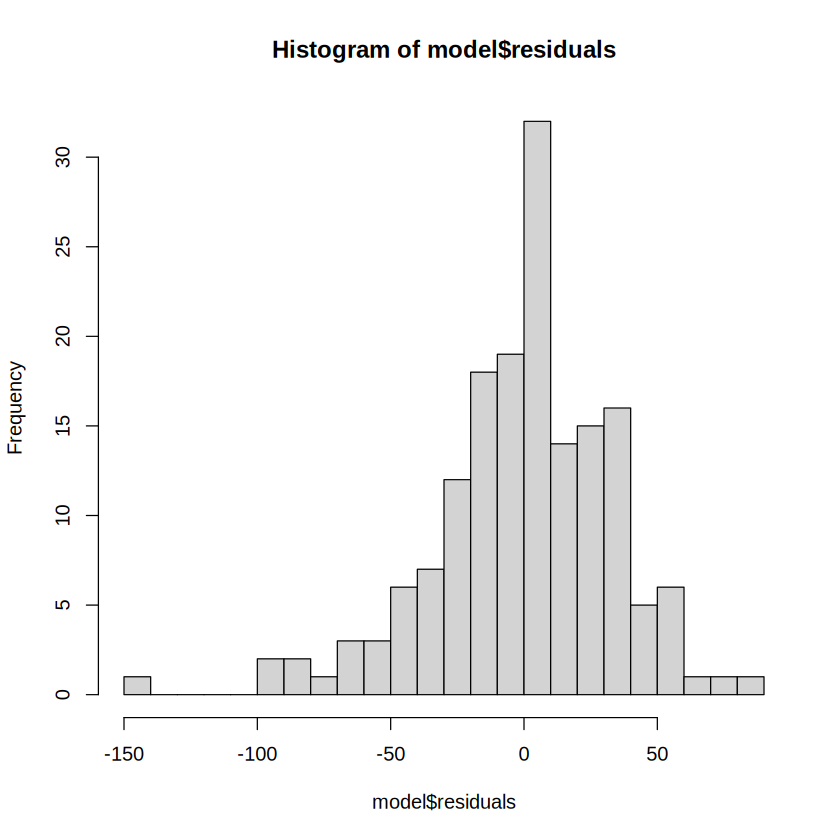


	studentized Breusch-Pagan test

data:  model
BP = 4.5697, df = 3, p-value = 0.2062

[1] "H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)"


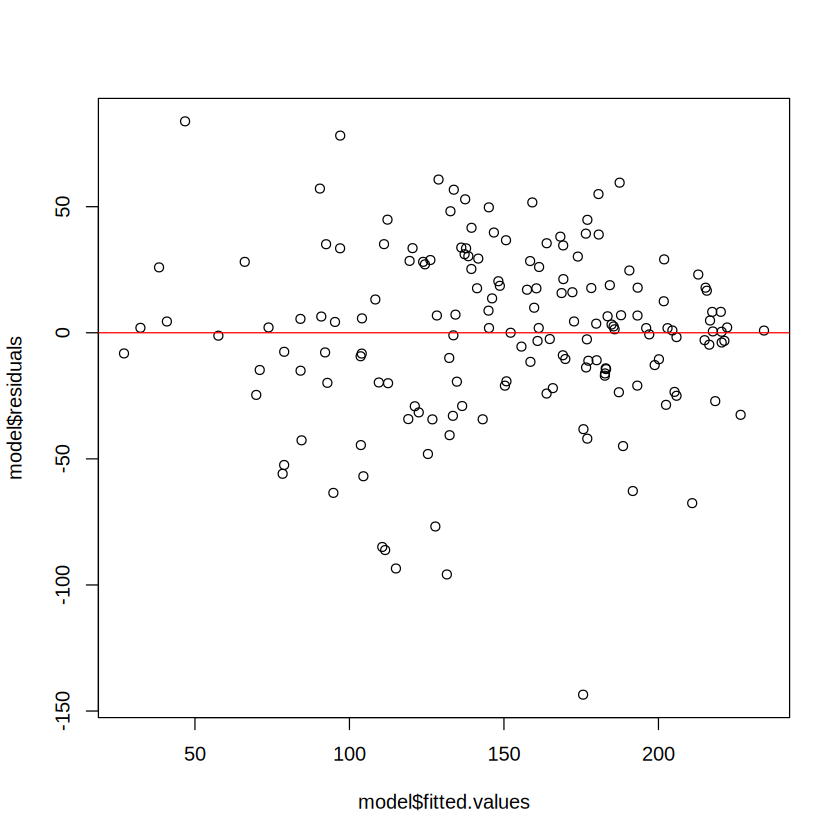

In [90]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_csm.2)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_csm.3 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_csm.3)

# Shapiro-Wilk normality test
# shapiro.test(residuals(best_model_csm.3))
CheckNormal(best_model_csm.3)

# Breusch-Pagan Test
# bptest(best_model_csm.3)
CheckHomos(best_model_csm.3)


### Dự đoán và đánh giá kết quả

[1] "MSE: 1231.319394"
[1] "RMSE: 35.090161"
[1] "MAE: 28.99513"
[1] "Correlation: 0.694378"
[1] "R^2 between y_pred & y_true: 0.482161"


[1] 35.09016

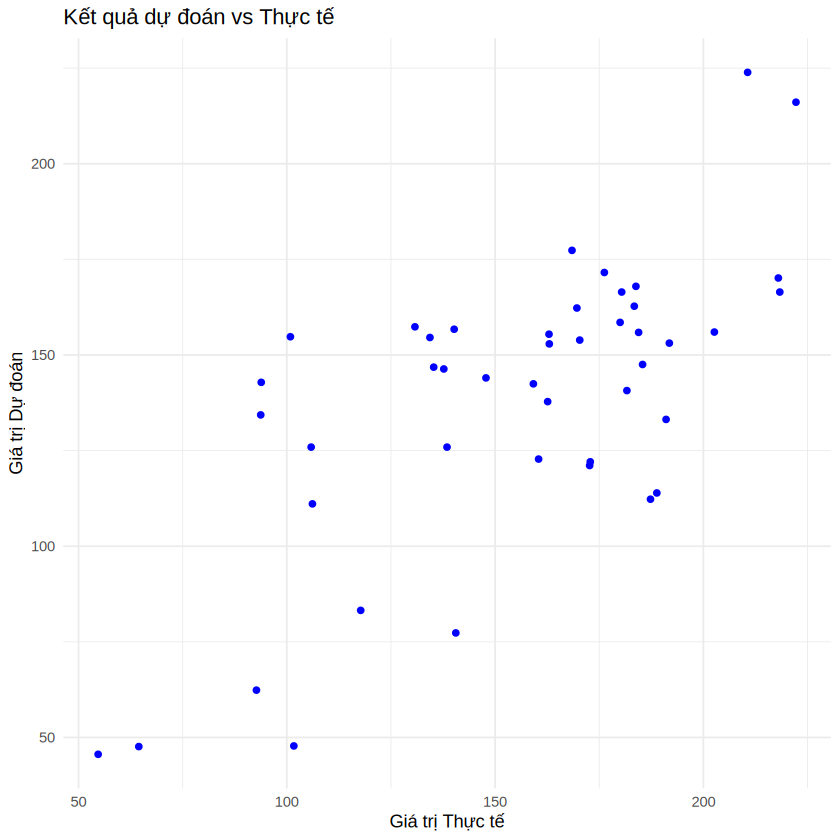

In [91]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_csm.2, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

metrics(results, test$Gross)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)

In [86]:
summary(best_model_csm.2)


Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
   Min     1Q Median     3Q    Max 
-71.07 -17.18   0.42  19.32  58.85 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -21.37468    9.25407  -2.310   0.0222 *  
Budget        0.65659    0.06692   9.811  < 2e-16 ***
Screens       3.27610    0.41667   7.863 4.99e-13 ***
Likes         1.14767    0.25277   4.540 1.09e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.76 on 162 degrees of freedom
Multiple R-squared:  0.7377,	Adjusted R-squared:  0.7329 
F-statistic: 151.9 on 3 and 162 DF,  p-value: < 2.2e-16


Dựa trên mô hình này, biến `Gross` có thể được giải thích bởi các biến độc lập:

```
Gross = -168.229  + 74.171 * Ratings + 29.807 * Dislikes
```

Ý nghĩa:
- Điểm xếp hạng càng cao thì doanh thu của một bộ phim cũng cao (hợp lý theo logic thông thường).
- Số lượt chê càng cao thì doanh thu của một bộ phim cũng cao. Điều này có thể lý giải, khi một bộ phim có nhiều bình luận tiêu cực, người ta sẽ có hứng thú đi xem nó để biết tại sao nó bị chê (yếu tố tò mò).
- Chỉ số R-squared hiệu chỉnh là 0.2246, tức là 22.46% phương sai của biến `Gross` có thể được giải thích bởi các biến độc lập của mô hình.

## Mô hình hóa bằng PCR

Principal Component Regression (PCR) là một kỹ thuật kết hợp Phân tích thành phần chính (PCA) và hồi quy tuyến tính để giải quyết đa cộng tuyến và giảm chiều trong các tập dữ liệu cao chiều. Các bước chính trong PCR là:
- **Principal Component Analysis (PCA)**: PCA biến đổi các biến dự báo ban đầu thành một tập hợp các biến mới, không tương quan được gọi là các thành phần chính. Các thành phần này là các tổ hợp tuyến tính của các biến ban đầu và được sắp xếp theo lượng phương sai mà chúng giải thích trong dữ liệu. Mỗi thành phần chính nắm bắt được phương sai tối đa có thể trong khi vẫn trực giao với các thành phần trước đó.
- **Regression**: Một tập hợp con các thành phần chính (giải thích phương sai lớn nhất) được chọn và sử dụng làm các yếu tố dự báo trong mô hình hồi quy tuyến tính để dự báo biến phản hồi. Bằng cách tập trung vào các thành phần chính nắm bắt được phương sai lớn nhất, PCR hướng đến mục tiêu xây dựng một mô hình hồi quy ổn định và dễ diễn giải hơn.

### Chuẩn bị dữ liệu

In [120]:
nPCs <- estim_ncpPCA(raw_data[, -c(1, 2, 4)])
print(nPCs)

# Xử lý missing value
csm_df <- imputePCA(raw_data[, -c(1, 2, 4)], ncp = nPCs$ncp, scale = TRUE)
csm_df <- csm_df$completeObs

$ncp
[1] 2

$criterion
           0            1            2            3            4            5 
1.105170e+15 6.996252e+14 4.736811e+14 5.889466e+14 7.572650e+14 1.068085e+15 



In [143]:
cleaned_df <- bc_transform(as.data.frame(csm_df))
# cleaned_df

[1] "Ratings"
[1] "Optimal lambda: 0.2"
[1] "Gross"
[1] "Optimal lambda: 0.2"
[1] "Budget"
[1] "Optimal lambda: 0.2"
[1] "Screens"
[1] "Optimal lambda: 0.2"
[1] "Sequel"
[1] "Optimal lambda: 0.2"
[1] "Sentiment"
[1] "Optimal lambda: 0.2"
[1] "Views"
[1] "Optimal lambda: 0.2"
[1] "Likes"
[1] "Optimal lambda: 0.2"
[1] "Comments"
[1] "Optimal lambda: 0.2"
[1] "AggregateFollowers"
[1] "Optimal lambda: 0.2"


In [144]:
# Ở đây sử dụng IQR để loại bỏ ngoại lai
Q1 <- quantile(cleaned_df$'Gross', 0.25)
Q3 <- quantile(cleaned_df$'Gross', 0.75)
IQR <- Q3 - Q1
lower_bound <- Q1 - 1.5 * IQR
upper_bound <- Q3 + 1.5 * IQR
outliers <- which(cleaned_df$'Gross' < lower_bound | cleaned_df$'Gross' > upper_bound)
print(outliers)

lower_bound <- Q1 - 3 * IQR
upper_bound <- Q3 + 3 * IQR
extreme_outliers <- which(cleaned_df$'Gross' < lower_bound | cleaned_df$'Gross' > upper_bound)
print(extreme_outliers)


[1] 69
integer(0)


In [125]:
split_ratio <- 0.8
split_index <- floor(nrow(cleaned_df) * split_ratio)

train = as.data.frame(cleaned_df[1:split_index,])
test = as.data.frame(cleaned_df[(split_index + 1):nrow(cleaned_df),])

### Khớp mô hình

In [126]:
pcr_model <- pcr(`Gross` ~ ., data = train, scale = TRUE, validation = "CV") # Fit PCR model with cross-validation

Đối số xác thực = “CV” chỉ định rằng xác thực chéo (cross-validation - CV) nên được sử dụng để xác thực mô hình. Xác thực chéo là một phương pháp mạnh mẽ để đánh giá hiệu suất dự đoán của một mô hình. Nó bao gồm việc phân vùng dữ liệu thành các tập hợp con, huấn luyện mô hình trên một số tập hợp con (bộ huấn luyện - training set) và xác thực nó trên các tập hợp con còn lại (bộ xác thực - validation set). Quá trình này được lặp lại nhiều lần để đảm bảo hiệu suất của mô hình là nhất quán và không phụ thuộc vào phân vùng dữ liệu cụ thể.

Bằng cách sử dụng xác thực chéo, mô hình ít có khả năng quá khớp với dữ liệu huấn luyện. Quá khớp xảy ra khi mô hình nắm bắt được nhiễu và các mẫu cụ thể trong dữ liệu huấn luyện không tổng quát hóa thành dữ liệu mới, chưa từng thấy. Xác thực chéo giúp phát hiện và giảm thiểu tình trạng quá khớp bằng cách kiểm tra mô hình trên các tập hợp con khác nhau của dữ liệu.

In [127]:
summary(pcr_model)

Data: 	X dimension: 184 9 
	Y dimension: 184 1
Fit method: svdpc
Number of components considered: 9

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           61.54    50.10    38.64    38.83    35.84    36.10    36.29
adjCV        61.54    50.05    38.56    38.75    35.71    35.99    36.20
       7 comps  8 comps  9 comps
CV       36.32    36.76    36.97
adjCV    36.22    36.63    36.81

TRAINING: % variance explained
       1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X        36.99    56.35    69.36    79.30    87.38    94.55    98.22    99.47
Gross    34.19    61.29    62.20    67.11    68.00    68.02    68.39    68.44
       9 comps
X       100.00
Gross    69.01


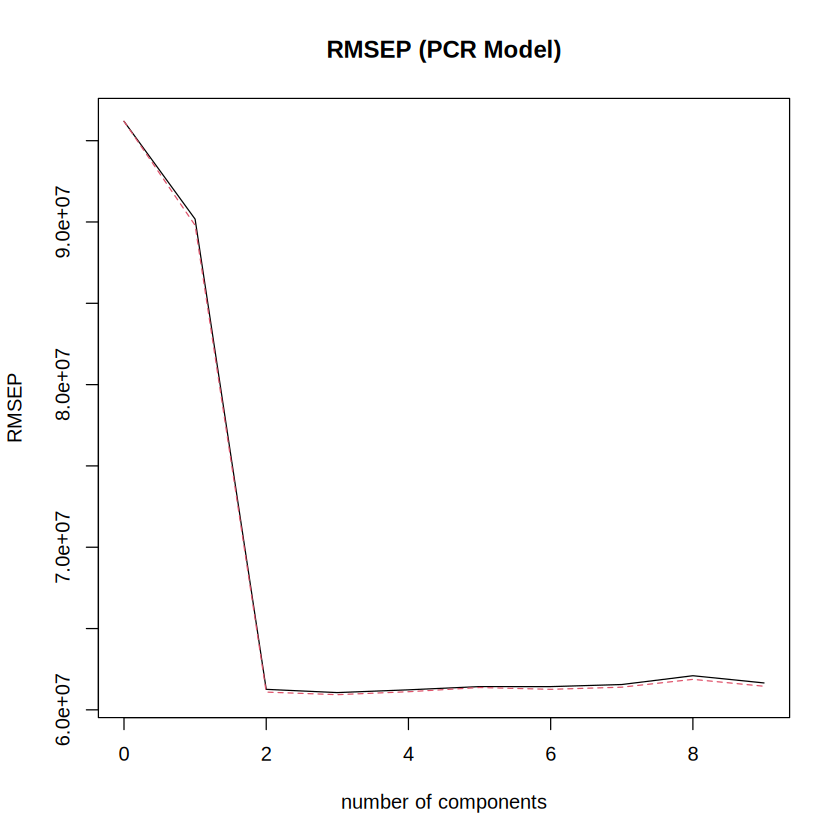

In [114]:
validationplot(pcr_model, val.type = "RMSEP", main = "RMSEP (PCR Model)")

**Quyết định số thành phần chính tối ưu**

Để quyết định được số thành phần chính tối ưu, chúng ta cần phải trung hòa giữa độ phức tạp của mô hình (tức là số lượng components) và RMSEP (Root Mean Squared Error of Prediction).

**Đánh giá**
- RMSEP Values: 8 components - 36.09 (nhỏ nhất)
- Variance Explained: 8 components - 67.61% khá gần với cực đại 11 components.

=> Chọn 11 components

In [128]:
optimal_number_of_components <- 2  # Optimal number of components based on the RMSEP plot and summary
predictions <- predict(pcr_model, ncomp = optimal_number_of_components, newdata = test)  

### Dự đoán và đánh giá

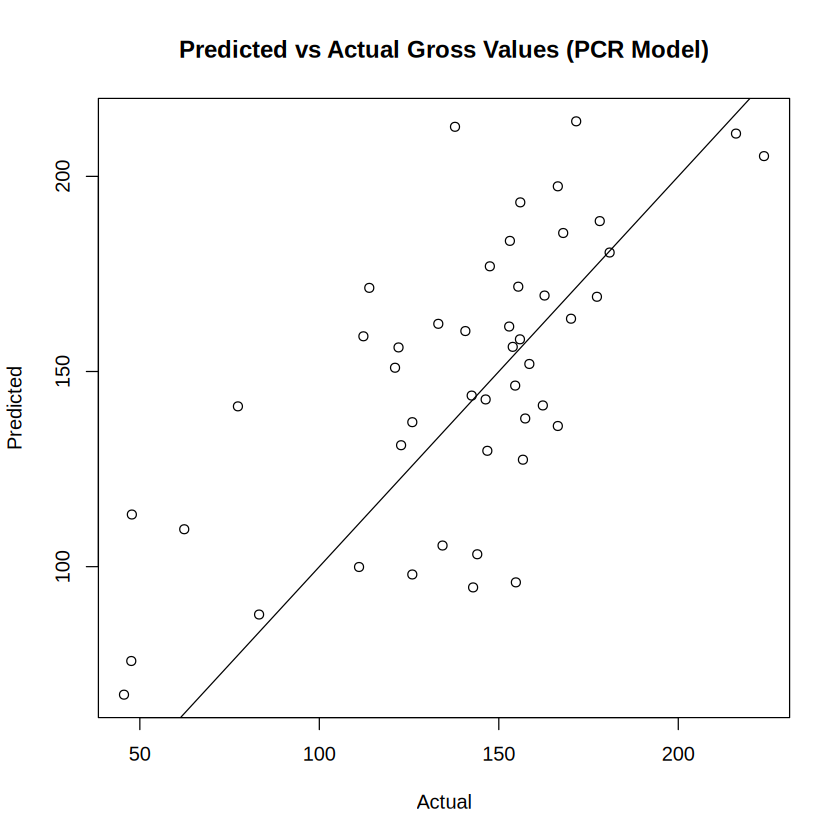

In [129]:
plot(test$`Gross`, predictions, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual Gross Values (PCR Model)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [130]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse <- sqrt(mean((test$`Gross` - predictions)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse)) 

[1] "RMSE:  31.2551481570935"


In [131]:
# Calculate the sum of squares of residuals
ss_res <- sum((test$`Gross` - predictions)^2)

# Calculate the total sum of squares
ss_tot <- sum((test$`Gross` - mean(test$`Gross`))^2)

# Calculate R-squared
r_squared <- 1 - (ss_res / ss_tot)

# Print R-squared
print(paste("R-squared: ", r_squared))

[1] "R-squared:  0.325958480590634"


Giá trị R-squared 0.3910 có nghĩa là 39.10% phương sai của biến phụ thuộc `Gross` được giải thích bởi các biến độc lập của mô hình.


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.98315, p-value = 4.99e-13

[1] "H0 rejected: the residuals are NOT distributed normally"


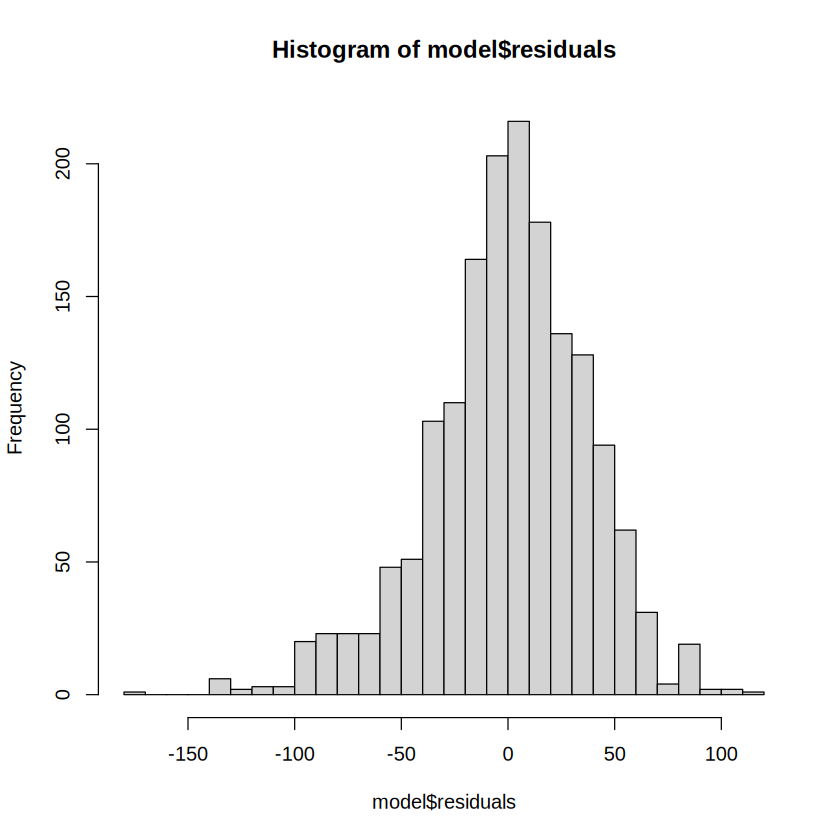


	studentized Breusch-Pagan test

data:  model
BP = 16.065, df = 9, p-value = 0.06554

[1] "H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)"


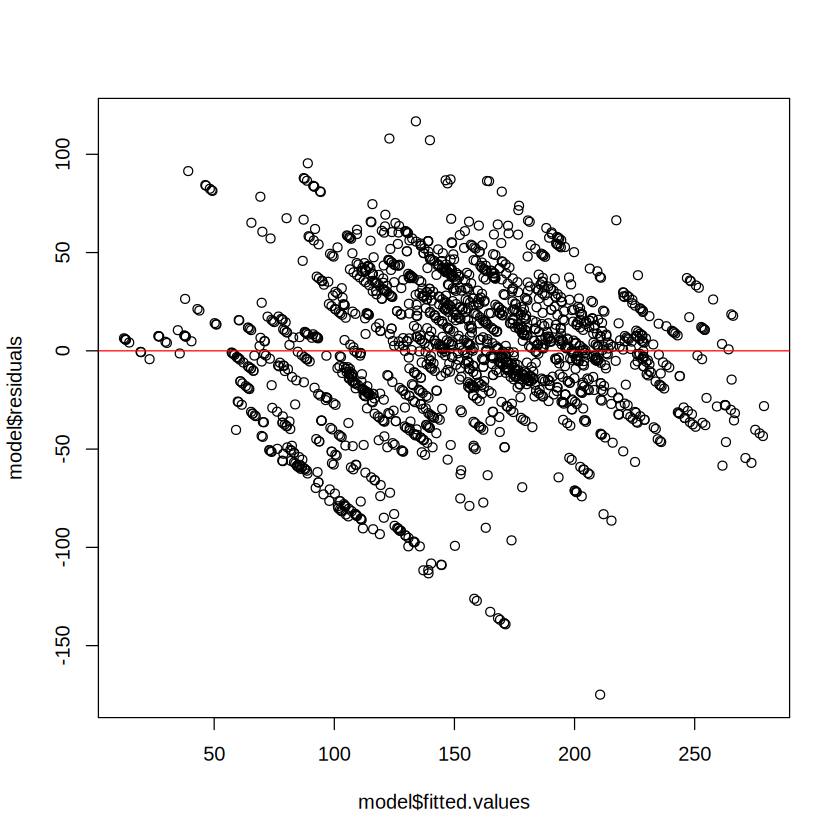

In [132]:
# Shapiro-Wilk normality test
# shapiro.test(residuals(pcr_model))
CheckNormal(pcr_model)

# Breusch-Pagan Test
# bptest(pcr_model)
CheckHomos(pcr_model)

## Mô hình hóa bằng PLS

Partial Least Squares Regression là một kỹ thuật, không giống như PCR, xem xét cả các biến dự báo và biến phản hồi trong quá trình giảm chiều. Các bước chính trong PLS là:
- Latent Variable Extraction: PLS trích xuất một tập hợp các biến tiềm ẩn (thành phần) tối đa hóa hiệp phương sai giữa các biến dự báo và biến phản hồi. Các thành phần này là các tổ hợp tuyến tính của các biến ban đầu, được chọn theo cách mà chúng nắm bắt được càng nhiều thông tin có liên quan càng tốt để dự đoán biến phản hồi. Điều này đảm bảo rằng các thành phần được trích xuất có liên quan trực tiếp đến kết quả quan tâm.
- Regression: Các biến tiềm ẩn sau đó được sử dụng làm biến dự báo trong mô hình hồi quy tuyến tính để dự báo biến phản hồi. Bằng cách kết hợp biến phản hồi vào quy trình trích xuất thành phần, PLS hướng đến mục tiêu cải thiện độ chính xác dự báo của mô hình hồi quy.

### Khớp mô hình

In [133]:
pls_model <- plsr(`Gross` ~ ., data = train, scale = TRUE, validation = "CV") # Fit PLS model with cross-validation

summary(pls_model)

Data: 	X dimension: 184 9 
	Y dimension: 184 1
Fit method: kernelpls
Number of components considered: 9

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           61.54    39.68    36.18    36.19    36.41    36.68    37.08
adjCV        61.54    39.65    36.12    36.10    36.30    36.56    36.91
       7 comps  8 comps  9 comps
CV       37.13    37.10    37.01
adjCV    36.96    36.93    36.85

TRAINING: % variance explained
       1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X        33.56    55.01    66.00    73.38    81.48    86.81    91.62    94.29
Gross    59.95    67.52    68.43    68.62    68.75    68.91    69.00    69.01
       9 comps
X       100.00
Gross    69.01


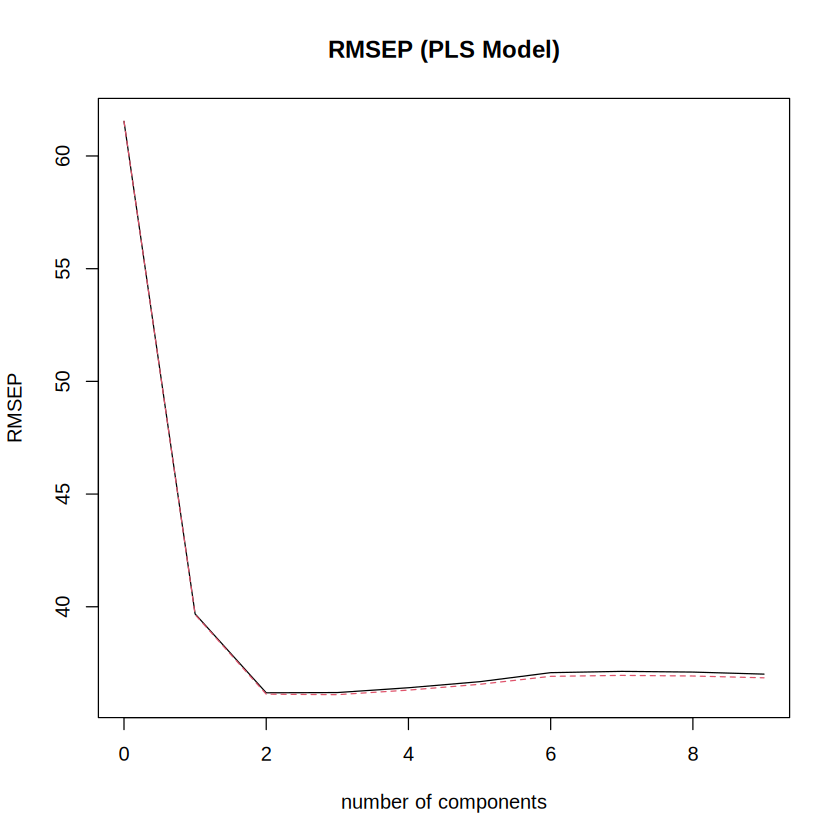

In [134]:
# Plotting the RMSEP (Root Mean Squared Error of Prediction) to find the optimal number of components
validationplot(pls_model, val.type = "RMSEP", main = "RMSEP (PLS Model)")

### Dự đoán và đánh giá

In [135]:
# Predict using the model and evaluate on the test set with optimal number of components
optimal_number_of_components <- 4  # Optimal number of components based on the RMSEP plot and summary
predictions2 <- predict(pls_model, ncomp = optimal_number_of_components, newdata = test)

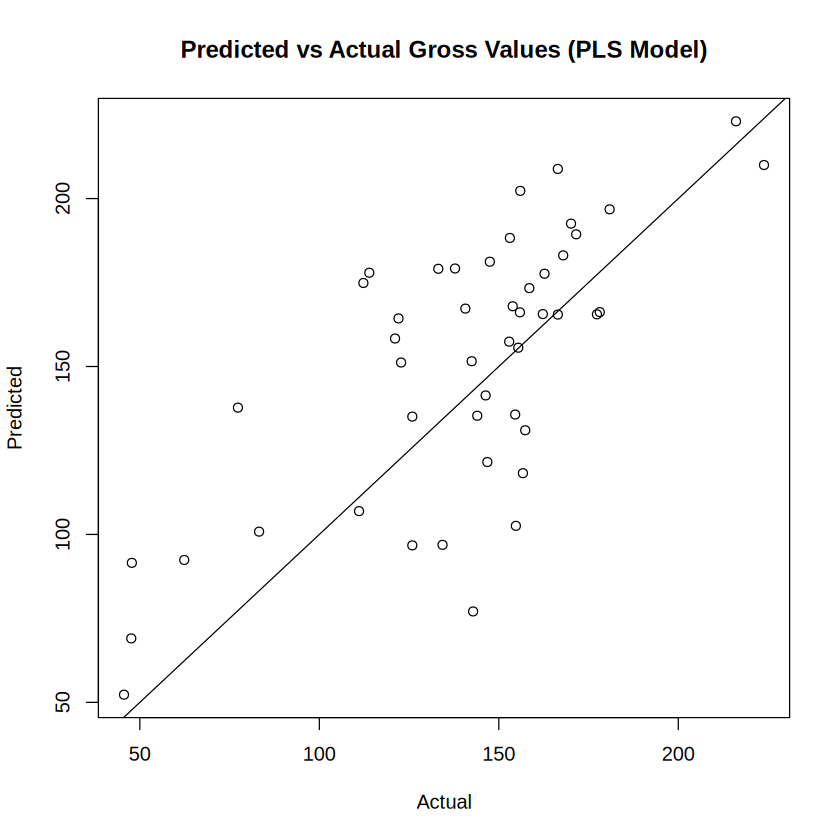

In [136]:
# Compare predictions with actual values
plot(test$`Gross`, predictions2, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual Gross Values (PLS Model)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [137]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse <- sqrt(mean((test$`Gross` - predictions2)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse)) 

[1] "RMSE:  31.1060582676585"


In [138]:
# Calculate the sum of squares of residuals
ss_res <- sum((test$`Gross` - predictions2)^2)

# Calculate the total sum of squares
ss_tot <- sum((test$`Gross` - mean(test$`Gross`))^2)

# Calculate R-squared
r_squared <- 1 - (ss_res / ss_tot)

# Print R-squared
print(paste("R-squared: ", r_squared))

[1] "R-squared:  0.332373621883562"


Giá trị R-squared 0.3984 có nghĩa là 39.84% phương sai của biến phụ thuộc `Gross` được giải thích bởi các biến độc lập của mô hình.


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.97724, p-value = 1.508e-15

[1] "H0 rejected: the residuals are NOT distributed normally"


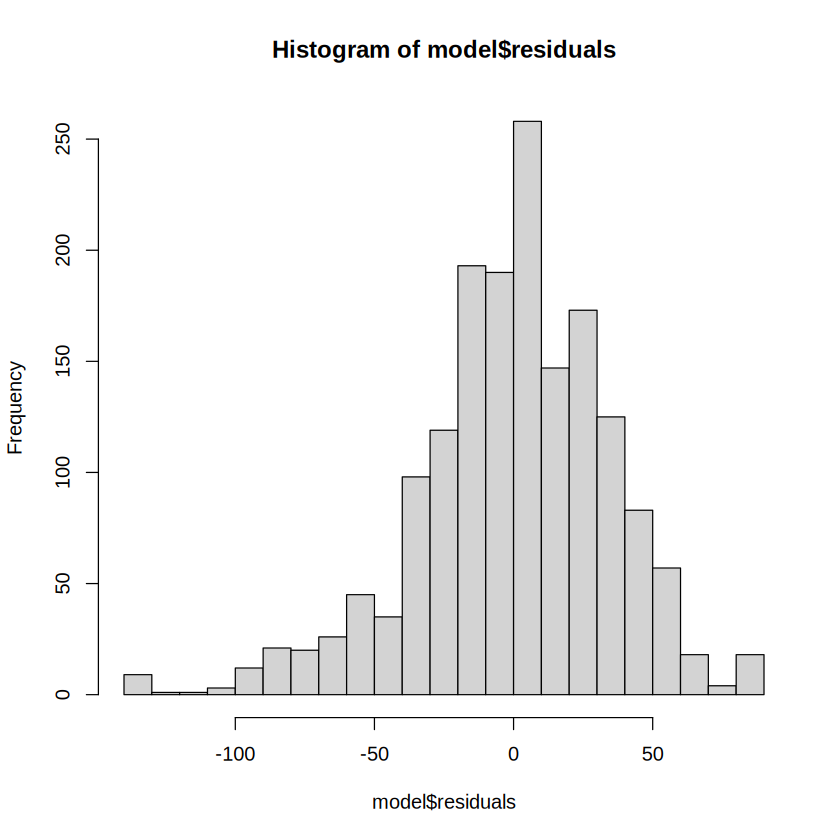


	studentized Breusch-Pagan test

data:  model
BP = 16.065, df = 9, p-value = 0.06554

[1] "H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)"


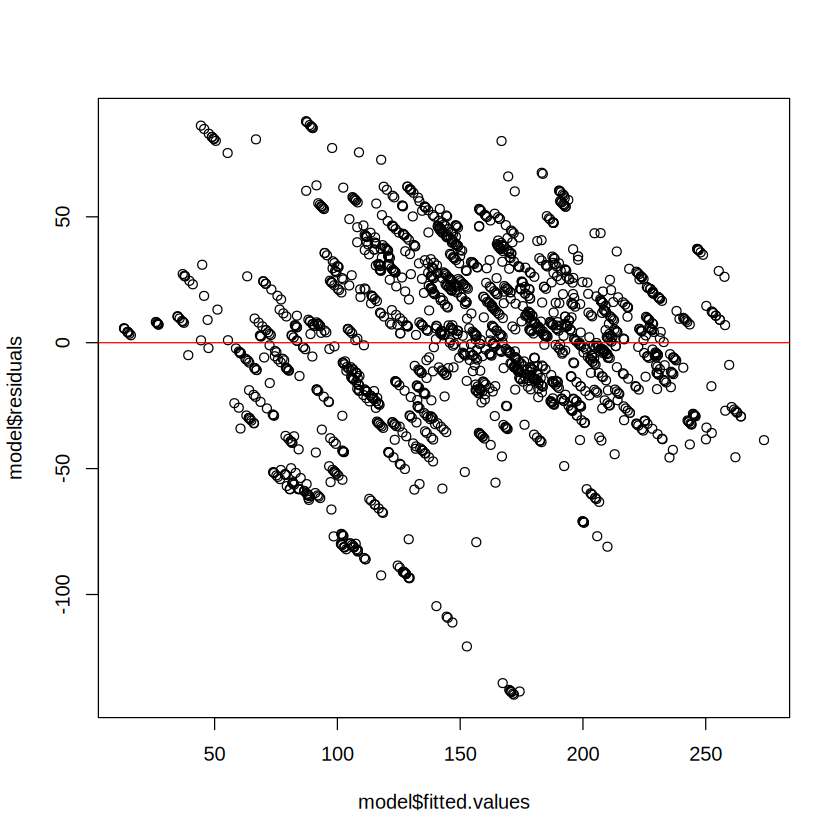

In [141]:
# Shapiro-Wilk normality test
# shapiro.test(residuals(pls_model))
CheckNormal(pls_model)

# Breusch-Pagan Test
# bptest(pls_model)
CheckHomos(pls_model)

## So sánh hai mô hình PCR và PLS

So sánh về hiệu suất về mặt độ đo RMSE
- PCR RMSE: 29.655
- PLS RMSE: 29.521

So sánh về hiệu suất về mặt độ đo R-squared
- PCR: 0.3909
- PLS: 0.3964

Nhận xét:
- RMSE đánh giá độ lớn trung bình của các lỗi giữa giá trị dự đoán và giá trị thực tế. RMSE thấp hơn đáng kể của mô hình PLS cho thấy độ chính xác vượt trội của nó trong việc dự đoán doanh thu Gross, làm nổi bật hiệu quả của nó trong các ứng dụng thực tế khi mà các dự đoán chính xác là rất quan trọng.
- R-squared là tỷ lệ phương sai trong biến phụ thuộc có thể dự đoán được từ các biến độc lập. R-bình phương cao hơn của mô hình PLS cho thấy nó nắm bắt được mức độ biến động lớn hơn trong tổng doanh thu Gross, cho thấy sự phù hợp tổng thể tốt hơn với dữ liệu.

Phân tích độ phức tạp
- PCR: Tập trung vào việc nắm bắt phương sai tối đa trong các yếu tố dự báo. Nó có hiệu quả trong việc giảm chiều và khám phá cấu trúc trong dữ liệu cao chiều. Tuy nhiên, hạn chế chính là các thành phần có phương sai cao nhất trong các yếu tố dự báo có thể không phải là thành phần có liên quan nhất để dự báo biến phản hồi.
- PLS: Nhằm mục đích tối đa hóa hiệp phương sai giữa các yếu tố dự báo và biến phản hồi. Phương pháp này không chỉ làm giảm tính cao chiều mà còn đảm bảo rằng các thành phần được giữ lại có liên quan trực tiếp đến kết quả quan tâm. Điểm mạnh của PLS nằm ở khả năng xác định các thành phần có khả năng dự báo phản hồi cao nhất, khiến nó rất phù hợp cho các nghiên cứu tập trung vào dự báo.

## Kết luận